# Time Series Analysis for Retail Store Data

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Create DataFrame from the image data
# This recreates the data shown in your image
df_wide = pd.read_csv('../data/sample-2/processed/revenue_ts_matrix.csv')

# Convert to long format for time series analysis
df_long = pd.melt(df_wide, id_vars=['StoreID'], var_name='Date', value_name='Sales')
df_long['Date'] = pd.to_datetime(df_long['Date'])

# Sort by StoreID and Date
df_long = df_long.sort_values(['StoreID', 'Date']).reset_index(drop=True)

print("Data converted to time series format:")
print(df_long.head(10))

Data converted to time series format:
   StoreID       Date    Sales
0        1 2022-01-01  6510.12
1        1 2022-01-02  3683.01
2        1 2022-01-03  1943.75
3        1 2022-01-04  6051.44
4        1 2022-01-05  1843.92
5        1 2022-01-06  3888.35
6        1 2022-01-07  1579.77
7        1 2022-01-08  4618.63
8        1 2022-01-09  4960.50
9        1 2022-01-10  7140.28


## EDA

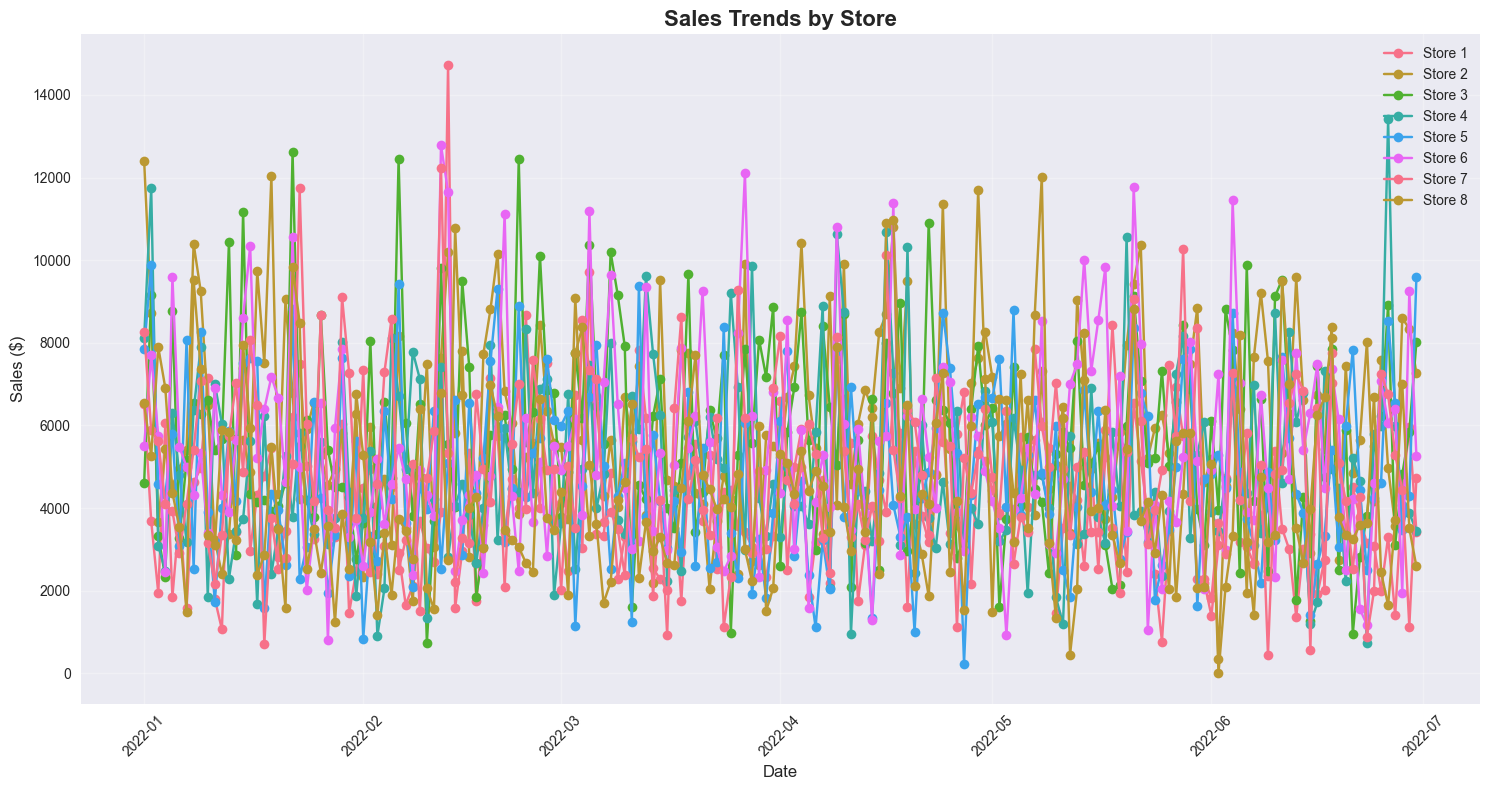


Sales Statistics by Store:
                mean          std     min       max
StoreID                                            
1        4151.034365  1899.064941  767.26  14728.32
2        5917.194807  2318.578260  336.99  12407.68
3        5712.086851  2427.132943  734.16  12622.10
4        4950.340000  2263.002416  733.43  13406.79
5        4797.012541  2151.894531  225.10   9878.44
6        5411.871657  2472.029107  794.94  12777.96
7        4912.210442  2162.759279  447.92  12236.29
8        4537.409116  2318.677755    0.00  12025.72


In [23]:
# Plot time series for all stores
plt.figure(figsize=(15, 8))
for store_id in df_long['StoreID'].unique():
    store_data = df_long[df_long['StoreID'] == store_id]
    plt.plot(store_data['Date'], store_data['Sales'], label=f'Store {store_id}', marker='o')

plt.title('Sales Trends by Store', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Sales ($)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Basic statistics by store
store_stats = df_long.groupby('StoreID')['Sales'].agg(['mean', 'std', 'min', 'max'])
print("\nSales Statistics by Store:")
print(store_stats)

## Stationarity Testing

In [24]:
def check_stationarity(ts, title):
    result = adfuller(ts.dropna())
    print(f'Results of Augmented Dickey-Fuller Test for {title}:')
    print(f'ADF Statistic: {result[0]:.6f}')
    print(f'p-value: {result[1]:.6f}')
    print(f'Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.3f}')
    
    if result[1] <= 0.05:
        print("Result: Series is stationary\n")
    else:
        print("Result: Series is non-stationary\n")
    
    return result[1] <= 0.05

# Check stationarity for each store
for store_id in df_long['StoreID'].unique():
    store_data = df_long[df_long['StoreID'] == store_id]
    is_stationary = check_stationarity(store_data['Sales'], f'Store {store_id}')
    
    # If non-stationary, check first difference
    if not is_stationary:
        print(f"Checking first difference for Store {store_id}:")
        sales_diff = store_data['Sales'].diff().dropna()
        check_stationarity(sales_diff, f'Store {store_id} (First Difference)')

Results of Augmented Dickey-Fuller Test for Store 1:
ADF Statistic: -10.523228
p-value: 0.000000
Critical Values:
	1%: -3.467
	5%: -2.878
	10%: -2.575
Result: Series is stationary

Results of Augmented Dickey-Fuller Test for Store 2:
ADF Statistic: -12.210564
p-value: 0.000000
Critical Values:
	1%: -3.467
	5%: -2.878
	10%: -2.575
Result: Series is stationary

Results of Augmented Dickey-Fuller Test for Store 3:
ADF Statistic: -14.078604
p-value: 0.000000
Critical Values:
	1%: -3.467
	5%: -2.878
	10%: -2.575
Result: Series is stationary

Results of Augmented Dickey-Fuller Test for Store 4:
ADF Statistic: -4.949311
p-value: 0.000028
Critical Values:
	1%: -3.469
	5%: -2.878
	10%: -2.576
Result: Series is stationary

Results of Augmented Dickey-Fuller Test for Store 5:
ADF Statistic: -4.163456
p-value: 0.000759
Critical Values:
	1%: -3.469
	5%: -2.878
	10%: -2.576
Result: Series is stationary

Results of Augmented Dickey-Fuller Test for Store 6:
ADF Statistic: -12.477995
p-value: 0.000000


## Time Series Decomposition

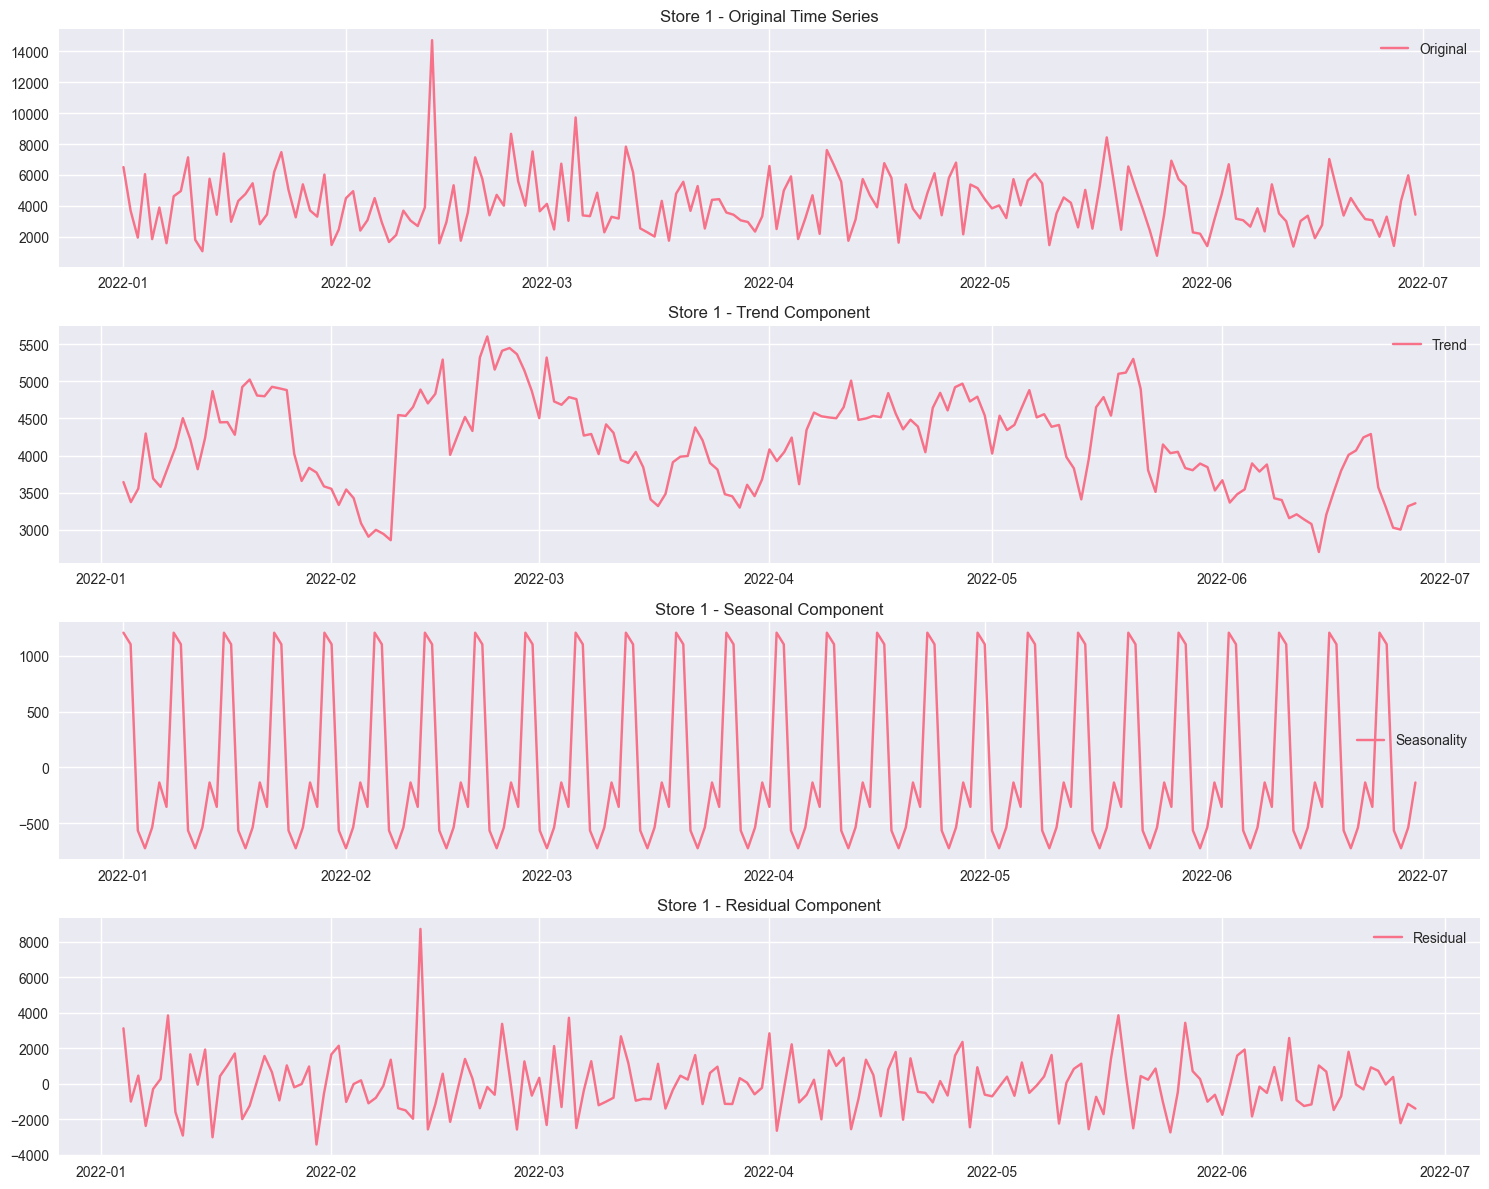

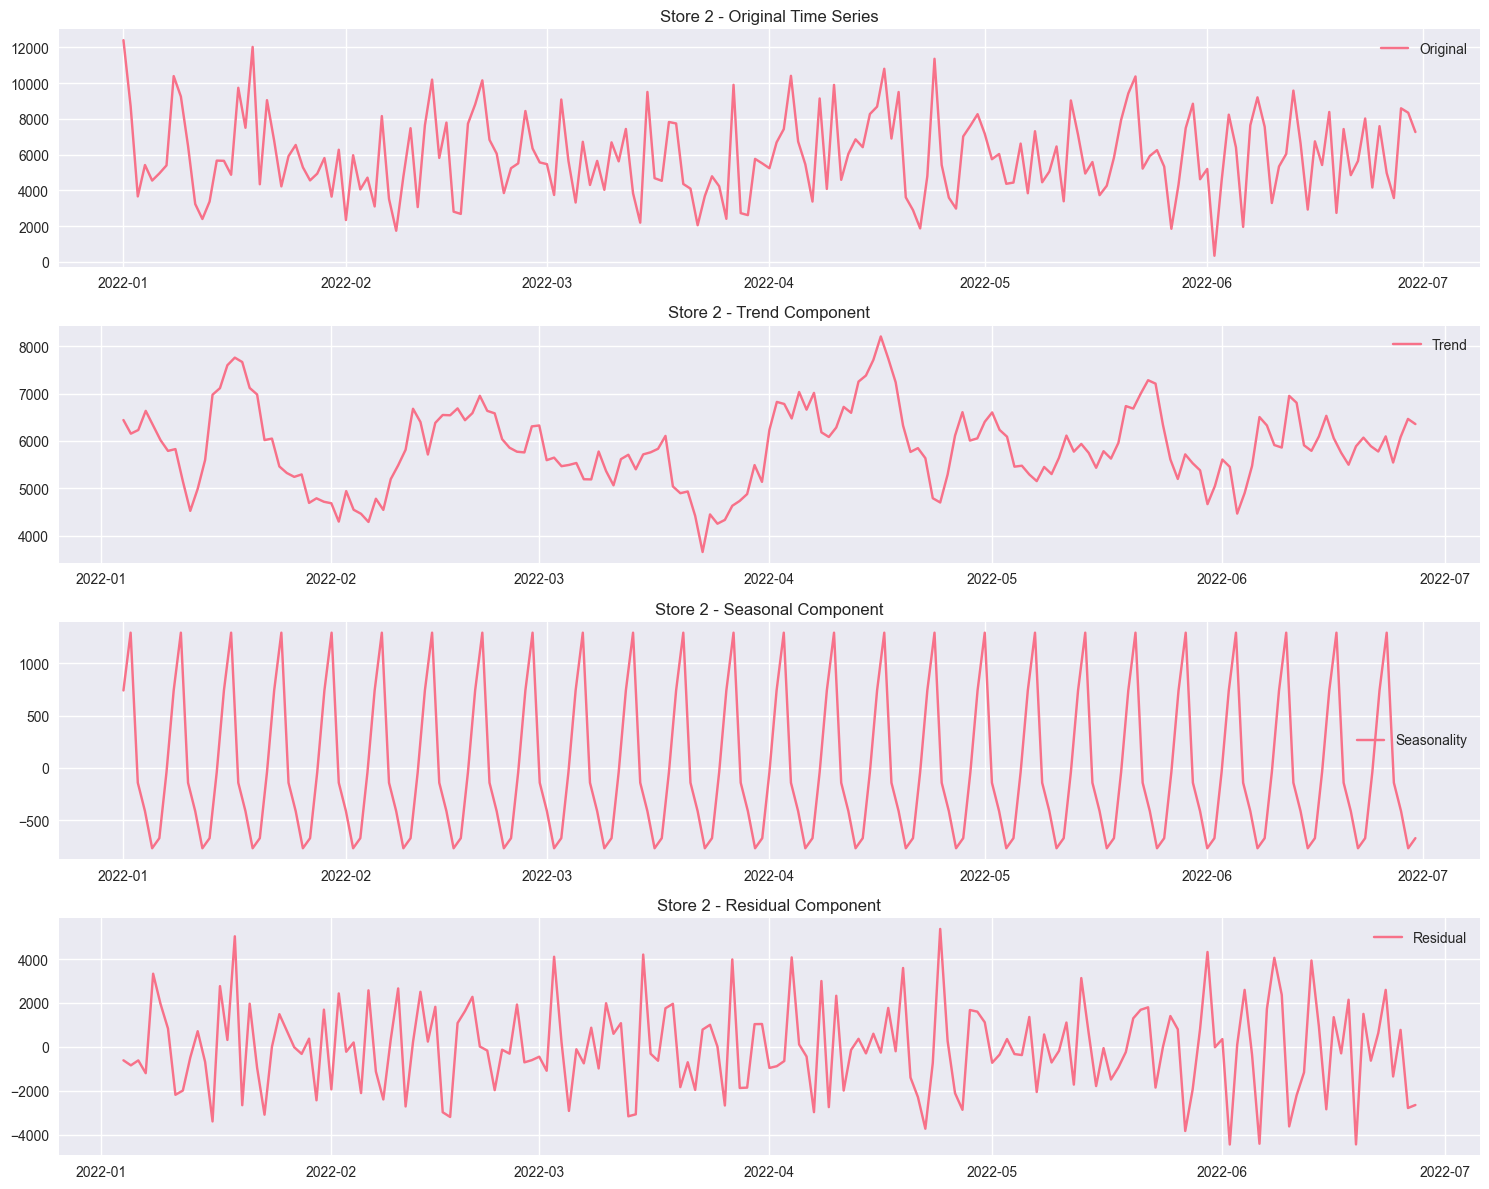

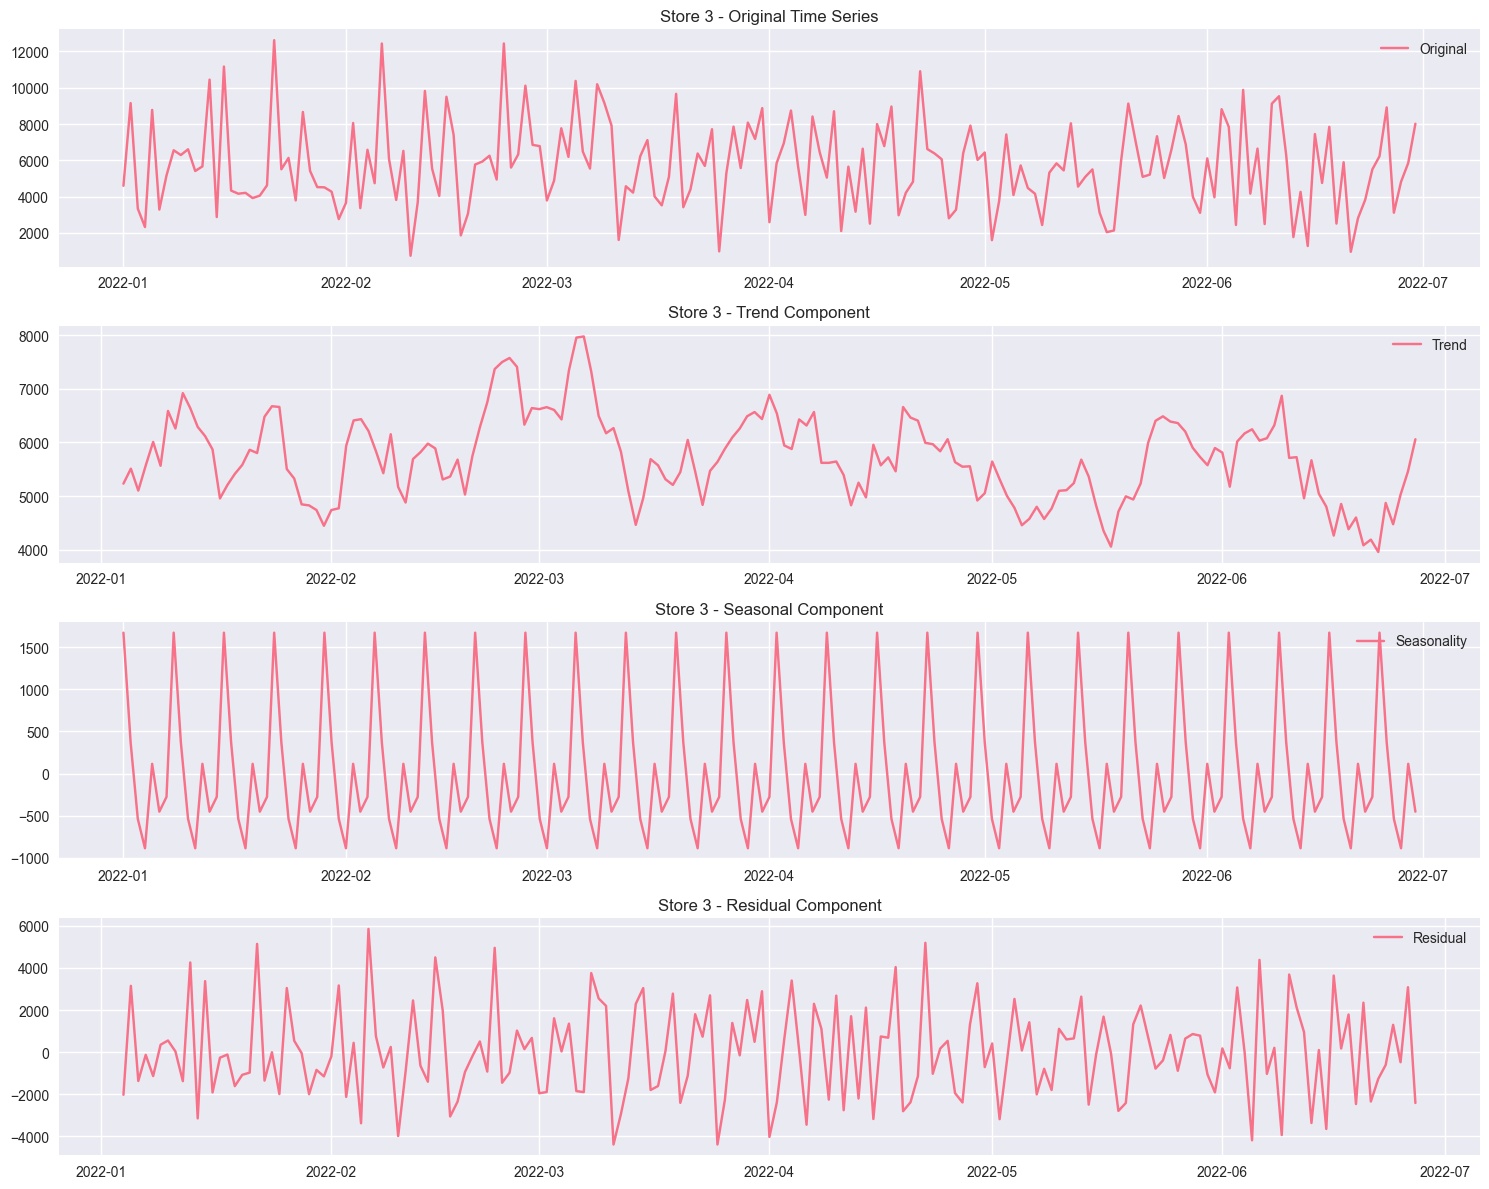

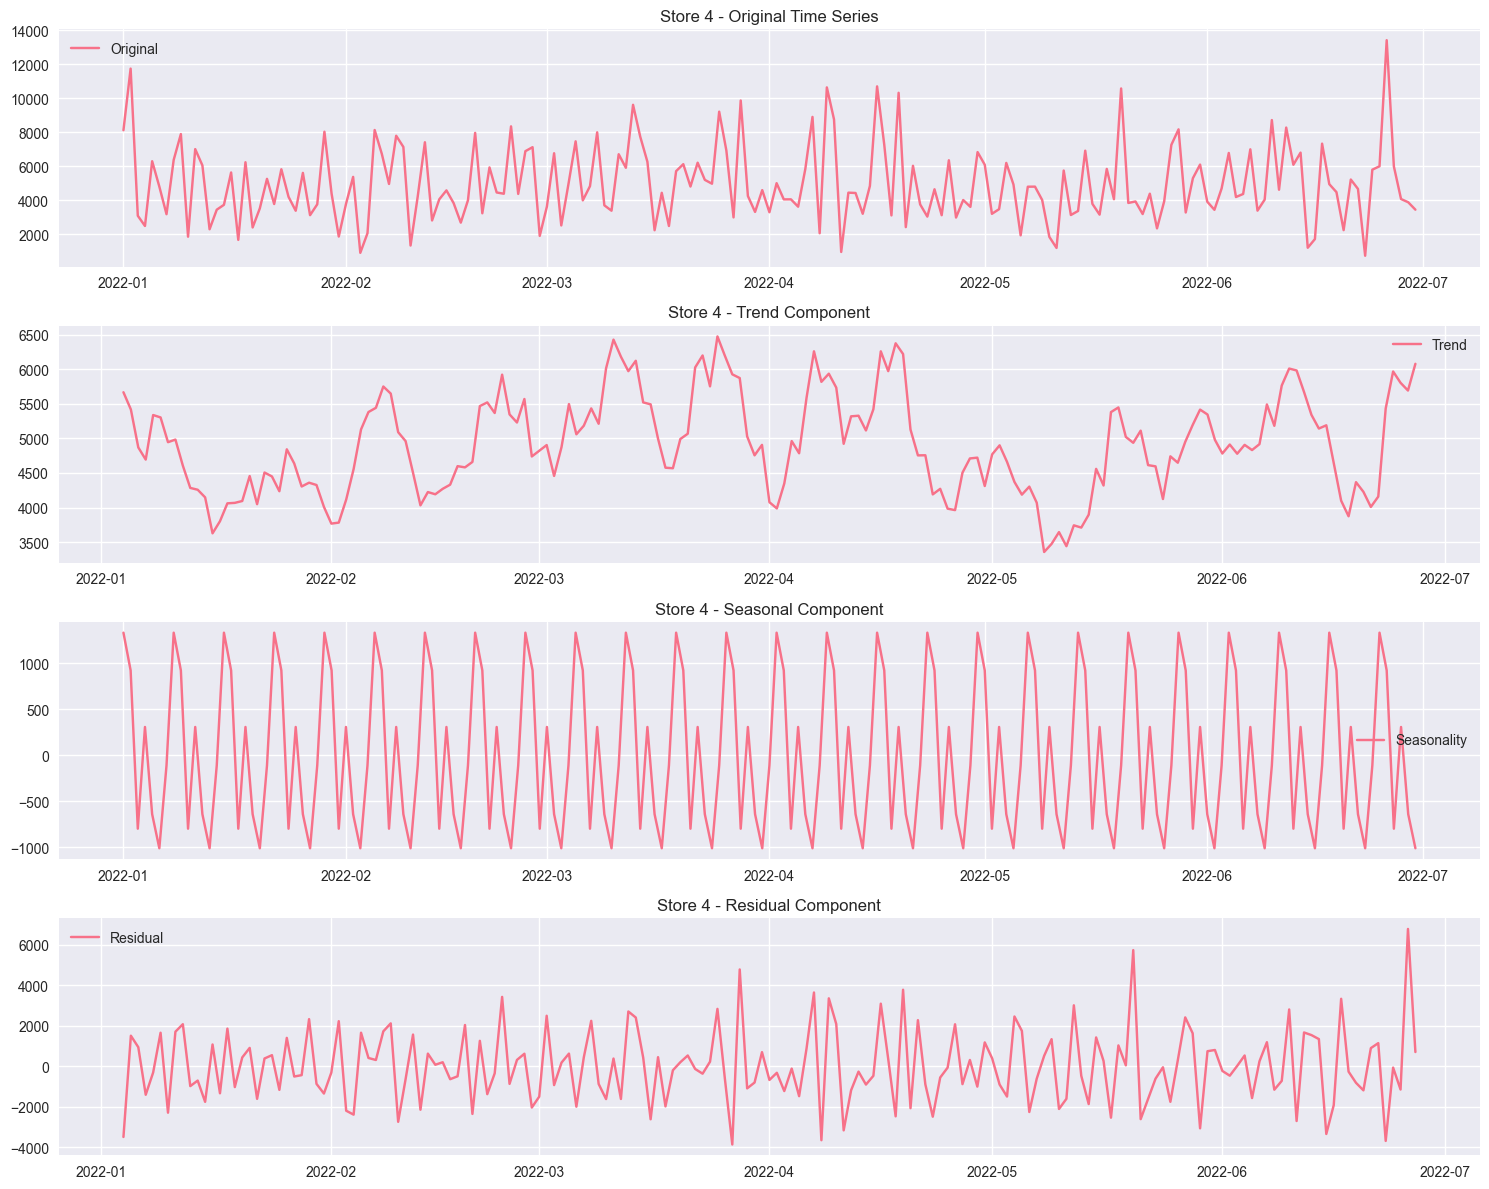

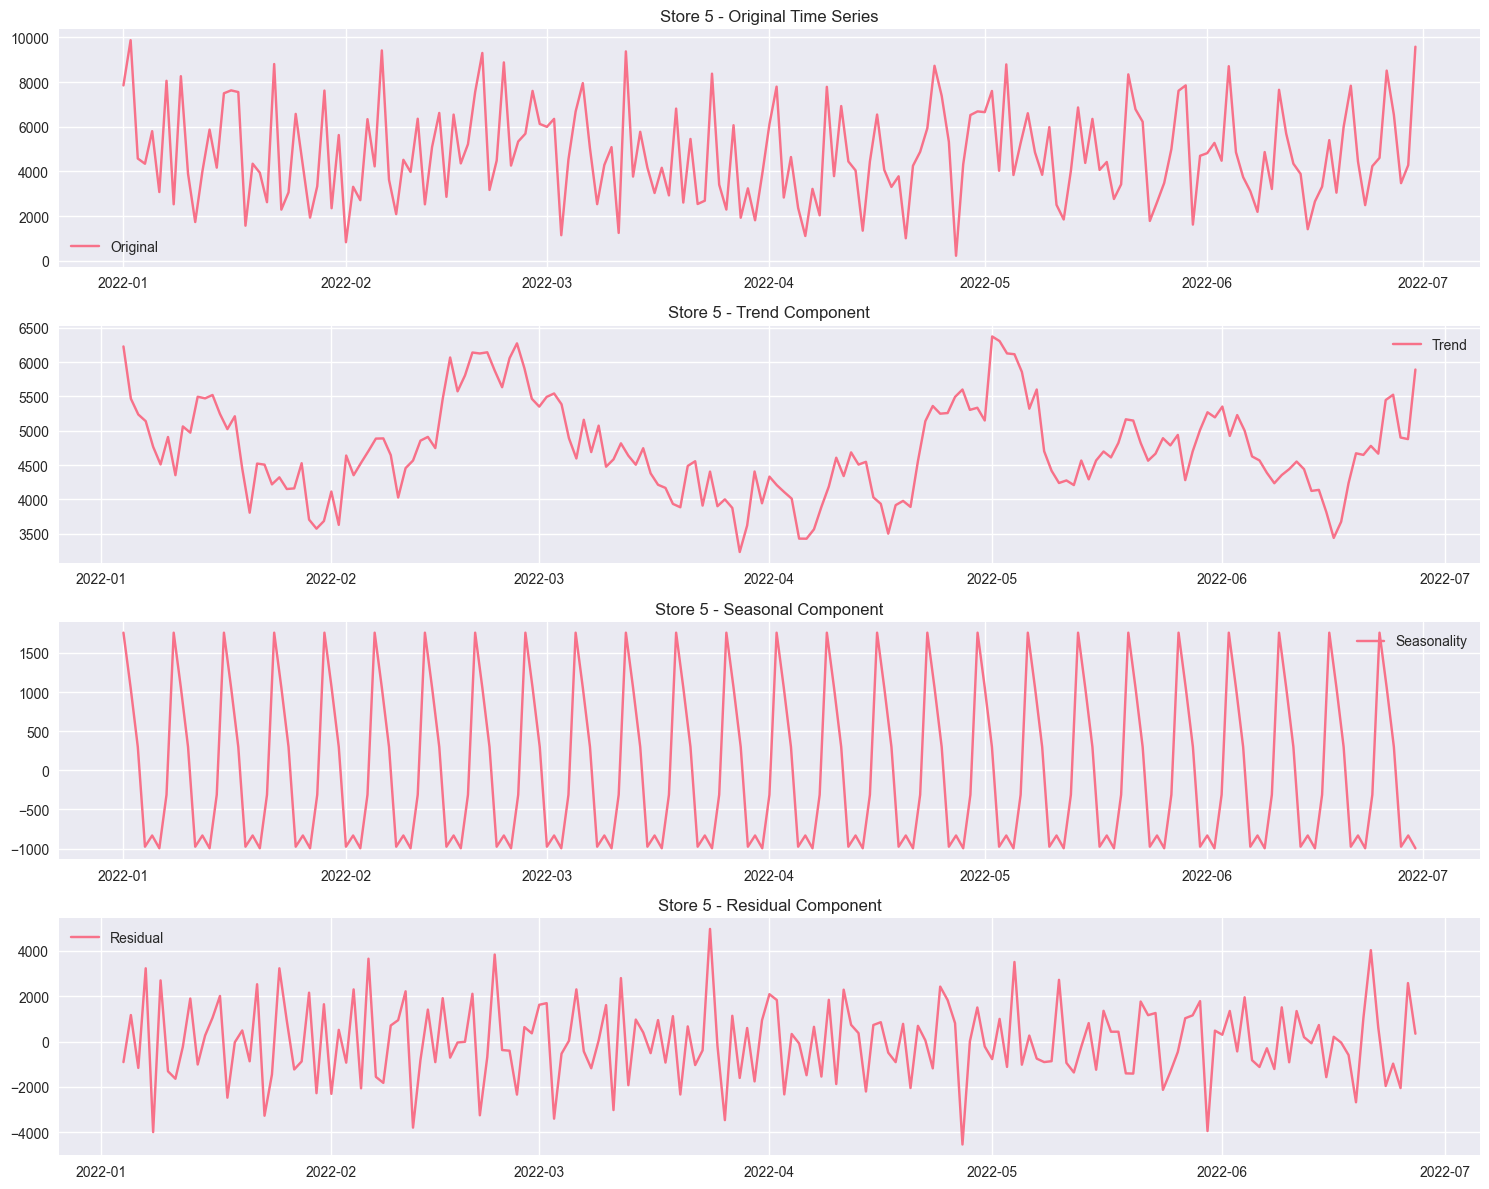

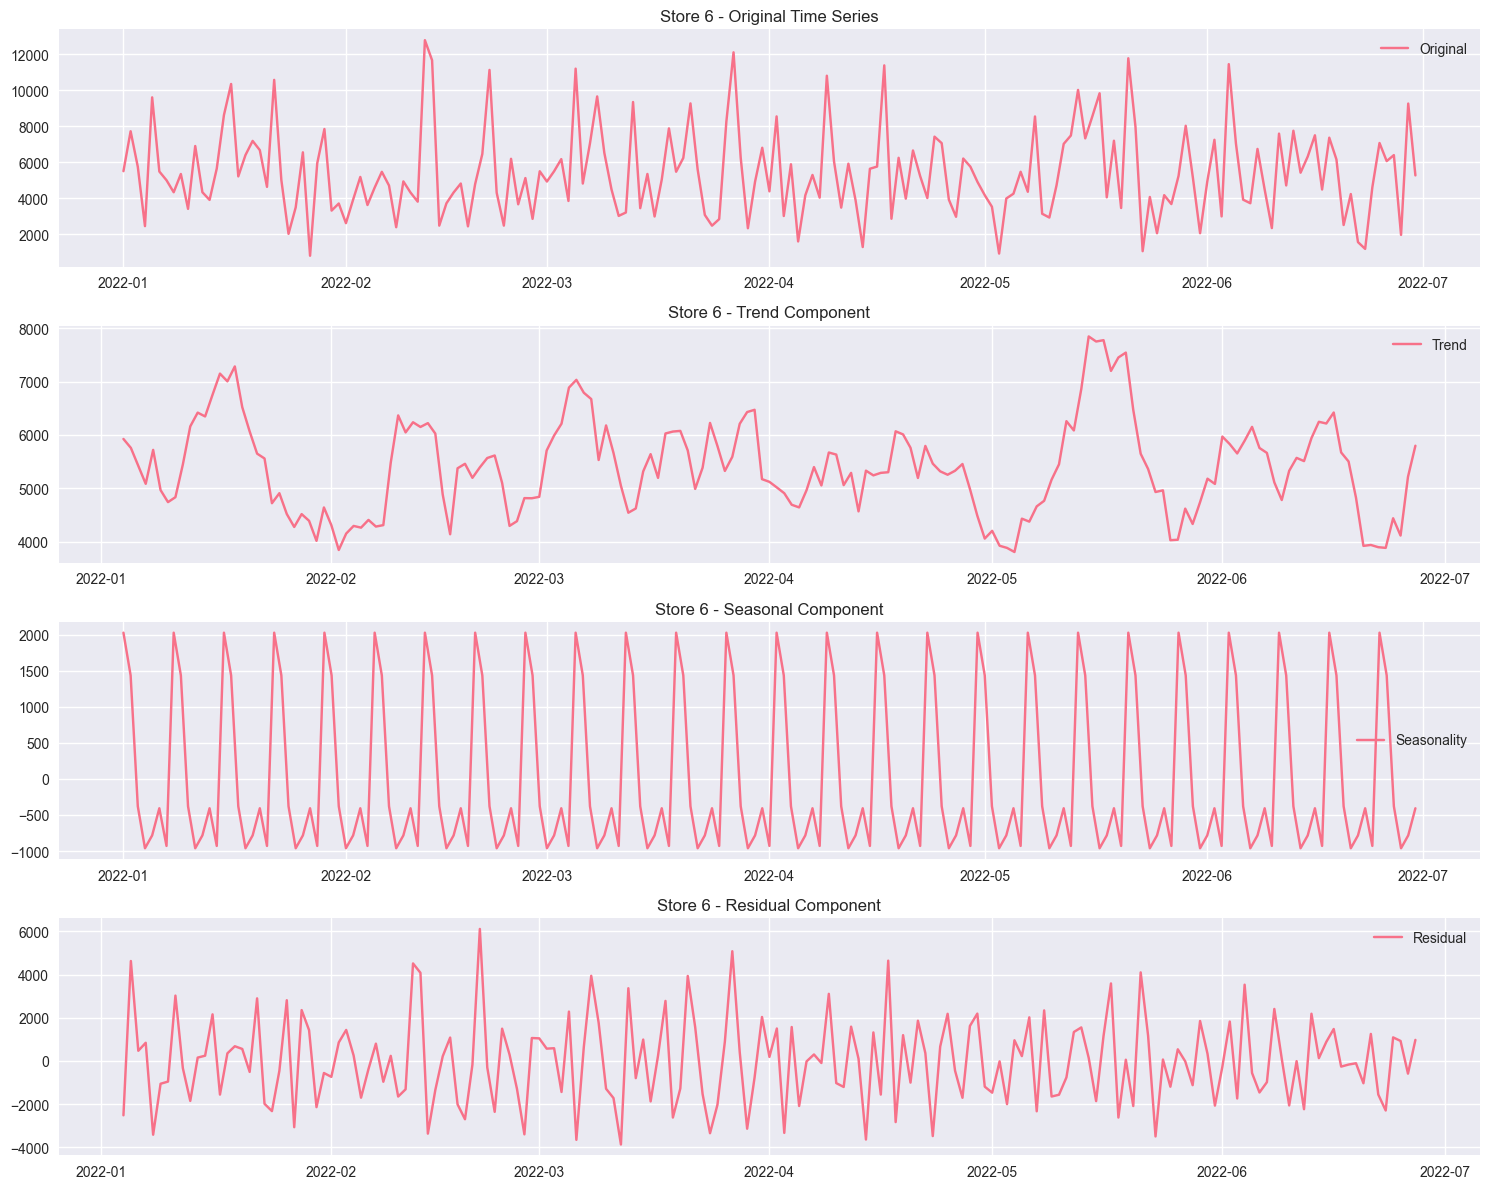

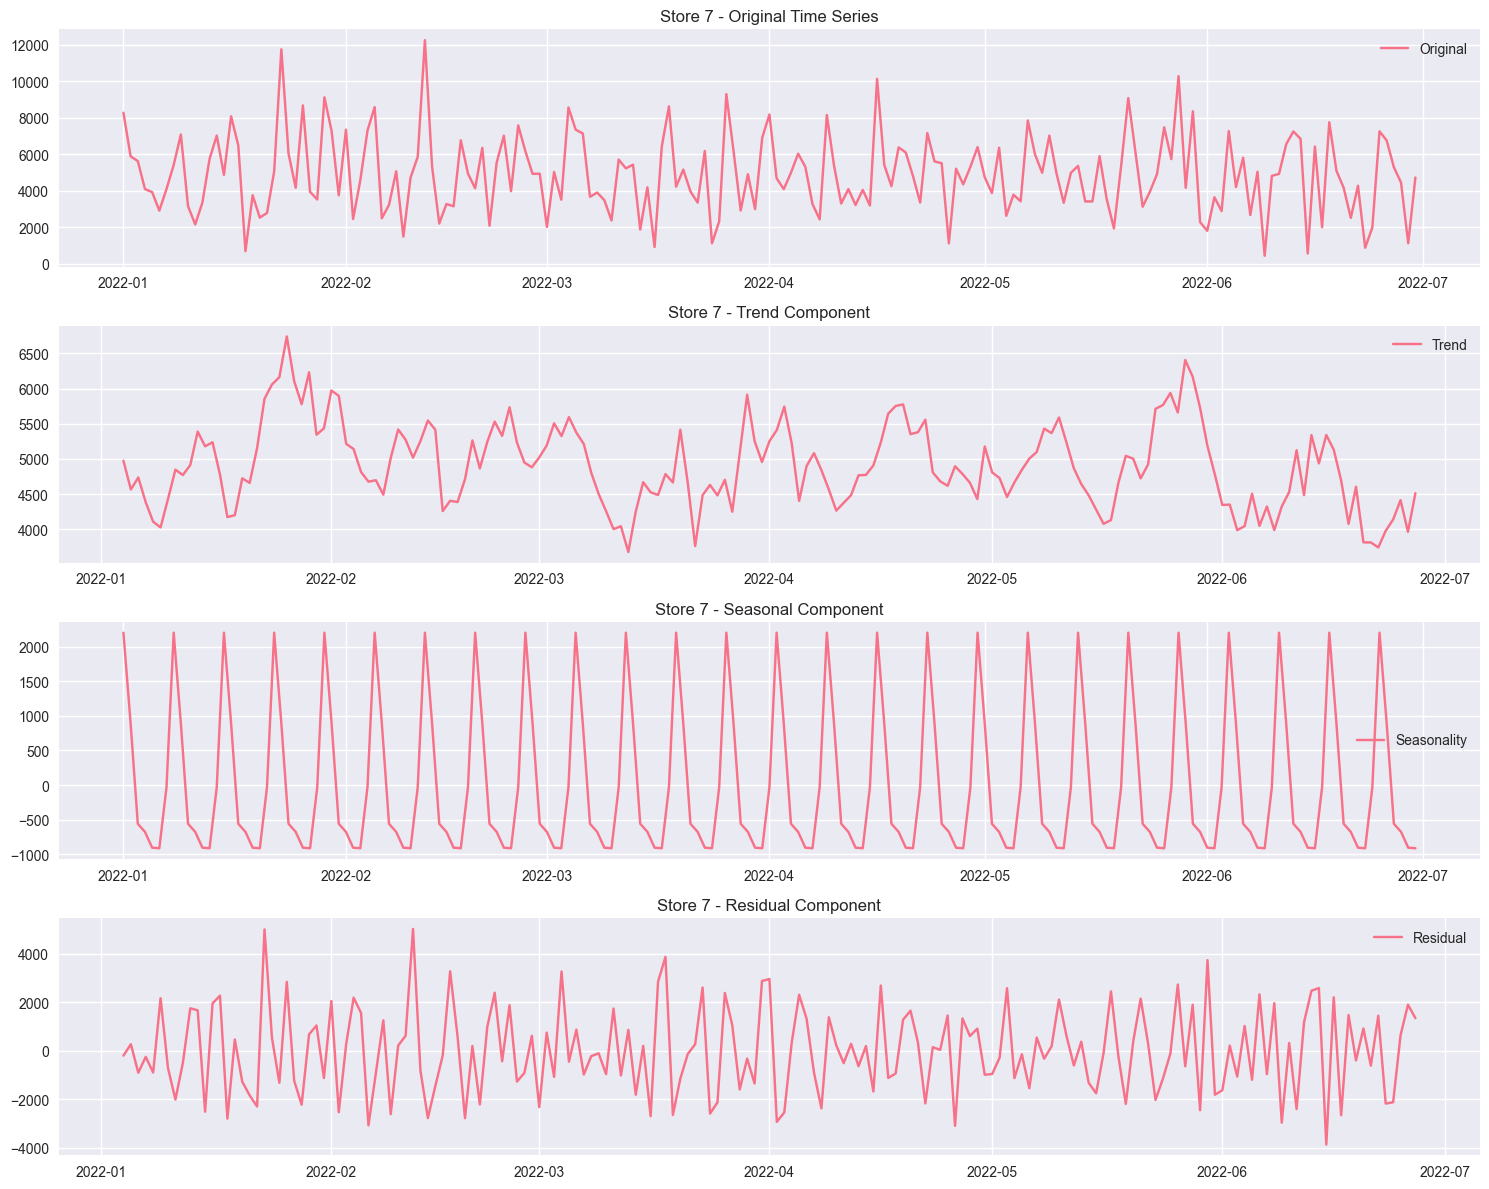

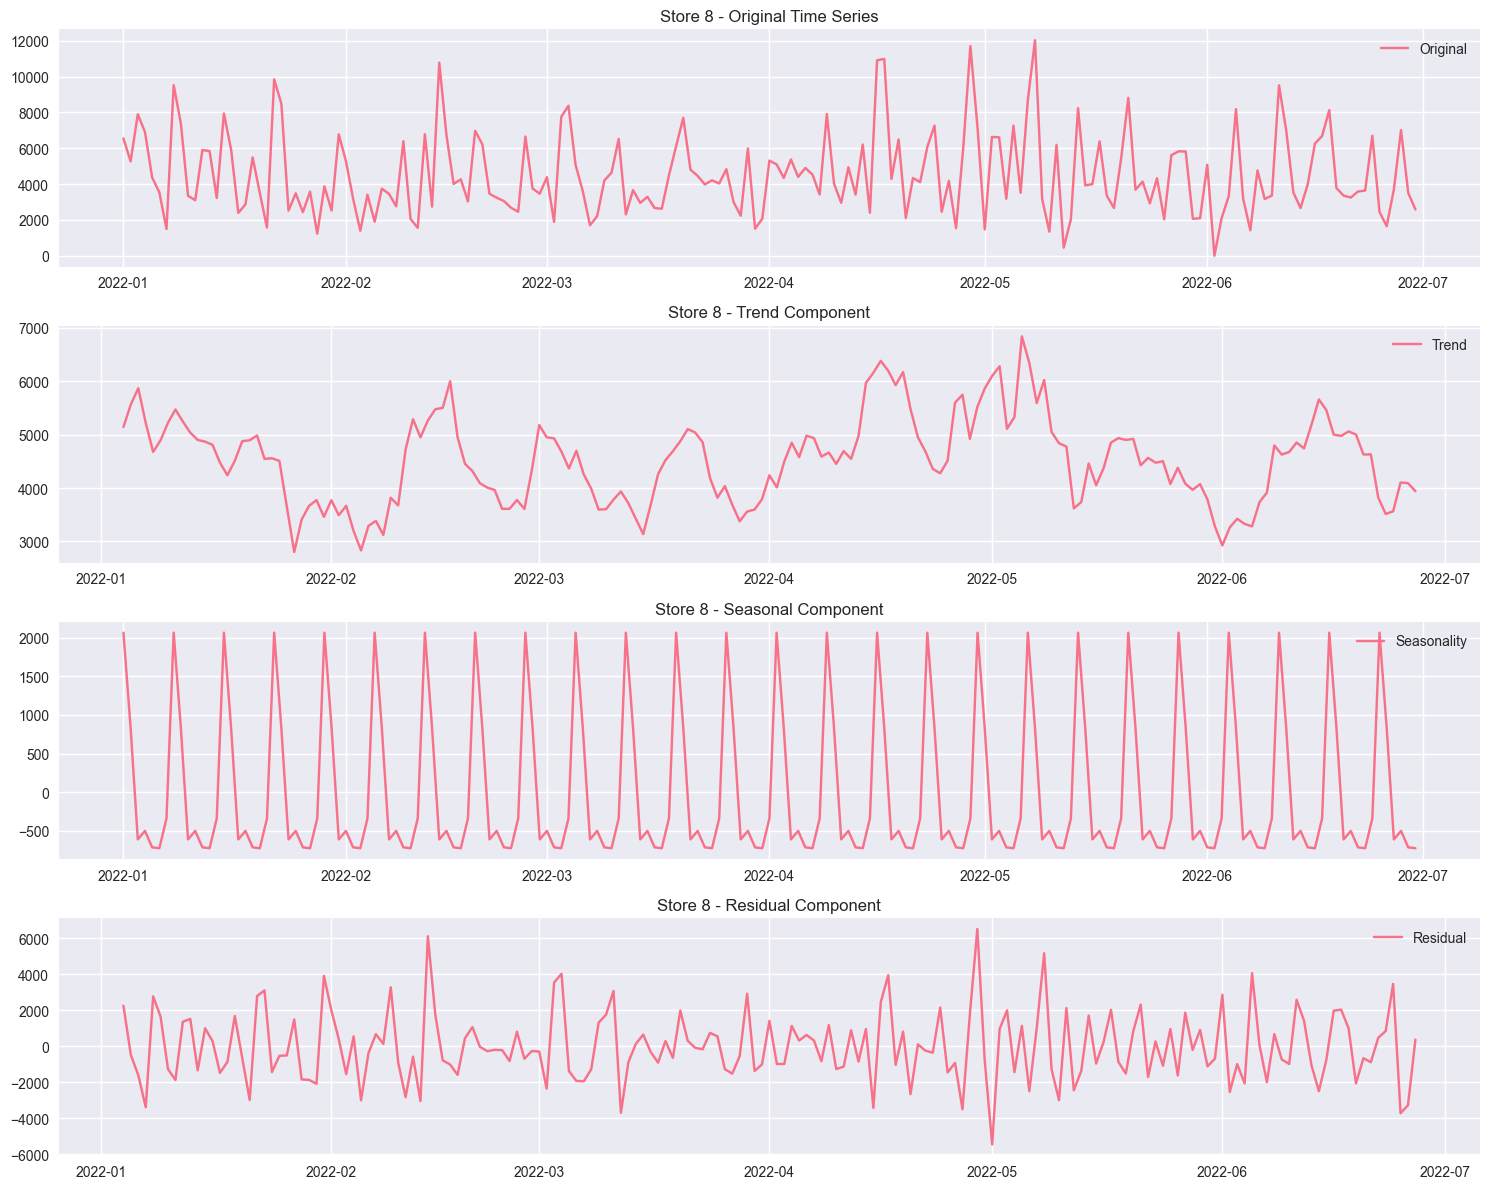

In [25]:
# For each store, decompose the time series if enough data points
for store_id in df_long['StoreID'].unique():
    store_data = df_long[df_long['StoreID'] == store_id]
    
    # Set date as index for decomposition
    store_ts = store_data.set_index('Date')['Sales']
    
    try:
        # Attempt decomposition (may not work well with limited data points)
        decomposition = seasonal_decompose(store_ts, model='additive', period=7)  # Assuming weekly pattern
        
        plt.figure(figsize=(15, 12))
        plt.subplot(4, 1, 1)
        plt.plot(store_ts, label='Original')
        plt.legend()
        plt.title(f'Store {store_id} - Original Time Series')
        
        plt.subplot(4, 1, 2)
        plt.plot(decomposition.trend, label='Trend')
        plt.legend()
        plt.title(f'Store {store_id} - Trend Component')
        
        plt.subplot(4, 1, 3)
        plt.plot(decomposition.seasonal, label='Seasonality')
        plt.legend()
        plt.title(f'Store {store_id} - Seasonal Component')
        
        plt.subplot(4, 1, 4)
        plt.plot(decomposition.resid, label='Residual')
        plt.legend()
        plt.title(f'Store {store_id} - Residual Component')
        
        plt.tight_layout()
        plt.show()
    except:
        print(f"Note: Not enough data points for decomposition for Store {store_id}")
        # Alternative visualization with just the original time series
        plt.figure(figsize=(12, 6))
        plt.plot(store_ts)
        plt.title(f'Store {store_id} - Sales Time Series')
        plt.show()

## ARIMA Modeling

In [26]:
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

def build_improved_arima_model(store_id, train, test):
    print(f"\nBuilding optimized ARIMA model for Store {store_id}")
    
    # Find optimal parameters automatically
    auto_model = auto_arima(train, 
                           seasonal=False,  # Set to True if you suspect seasonality
                           start_p=0, start_q=0, max_p=3, max_q=3, max_d=2,
                           trace=True,  # Print model evaluation results
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True)
    
    print(f"Best ARIMA order for Store {store_id}: {auto_model.order}")
    
    # Build ARIMA with optimal parameters
    model = ARIMA(train, order=auto_model.order)
    fitted_model = model.fit()
    print(fitted_model.summary())
    
    # Rest of your code remains the same...
    forecast_steps = len(test)
    forecast = fitted_model.forecast(steps=forecast_steps)
    
    # Calculate metrics
    mse = mean_squared_error(test, forecast)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(test, forecast)
    mape = np.mean(np.abs((test - forecast) / test)) * 100 if len(test) > 0 else 0
    
    print(f"Model Performance Metrics:")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"MAPE: {mape:.2f}%")
    
    return fitted_model, forecast, (mse, rmse, mae, mape)

In [27]:
# Split data for each store into training and testing sets
def train_test_split_ts(store_data, test_size=0.3):
    n = len(store_data)
    train_size = int(n * (1 - test_size))
    train = store_data[:train_size]
    test = store_data[train_size:]
    return train, test

# Function to build and evaluate ARIMA model
def build_arima_model(store_id, train, test, order=(1,1,1)):
    print(f"\nBuilding ARIMA model for Store {store_id}")
    model = ARIMA(train, order=order)
    fitted_model = model.fit()
    print(fitted_model.summary())
    
    # Forecast for test period
    forecast_steps = len(test)
    forecast = fitted_model.forecast(steps=forecast_steps)
    
    # Calculate metrics
    mse = mean_squared_error(test, forecast)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(test, forecast)
    mape = np.mean(np.abs((test - forecast) / test)) * 100 if len(test) > 0 else 0
    
    print(f"Model Performance Metrics:")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"MAPE: {mape:.2f}%")
    
    return fitted_model, forecast, (mse, rmse, mae, mape)

# Dictionary to store results for comparison
results = {}

# Process each store
for store_id in df_long['StoreID'].unique():
    store_data = df_long[df_long['StoreID'] == store_id]
    store_ts = store_data.set_index('Date')['Sales']
    
    # Split data
    train, test = train_test_split_ts(store_ts, test_size=0.3)
    
    # Try different ARIMA orders based on data characteristics
    # For simplicity, we'll use (1,1,1) for all stores, but you could optimize this
    model, forecast, metrics = build_improved_arima_model(store_id, train, test)
    results[store_id] = {
        'model': model,
        'forecast': forecast,
        'metrics': metrics,
        'train': train,
        'test': test
    }


Building optimized ARIMA model for Store 1
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2490.588, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2362.122, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2429.050, Time=0.11 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=2337.131, Time=0.01 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=2317.378, Time=0.02 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.32 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=2275.743, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=2273.769, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=2273.726, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2273.168, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2273.350, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=2276.123, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.

## Visualizing Results and Forecasts

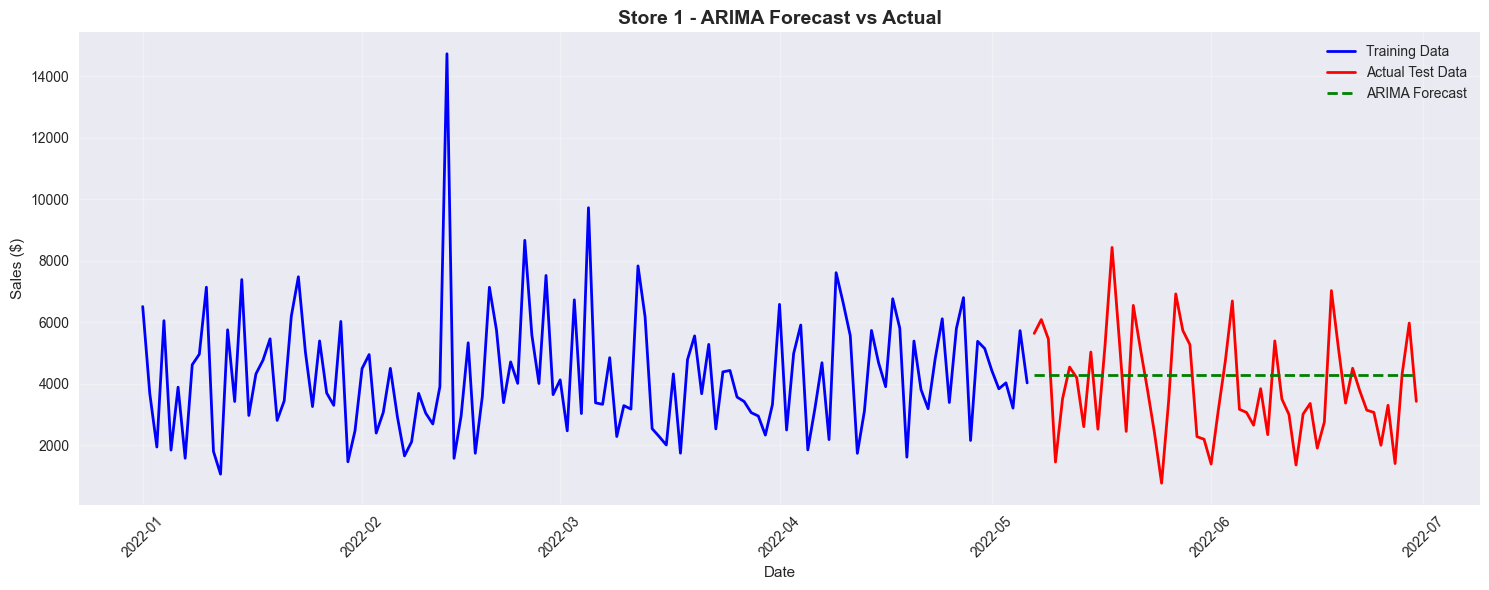

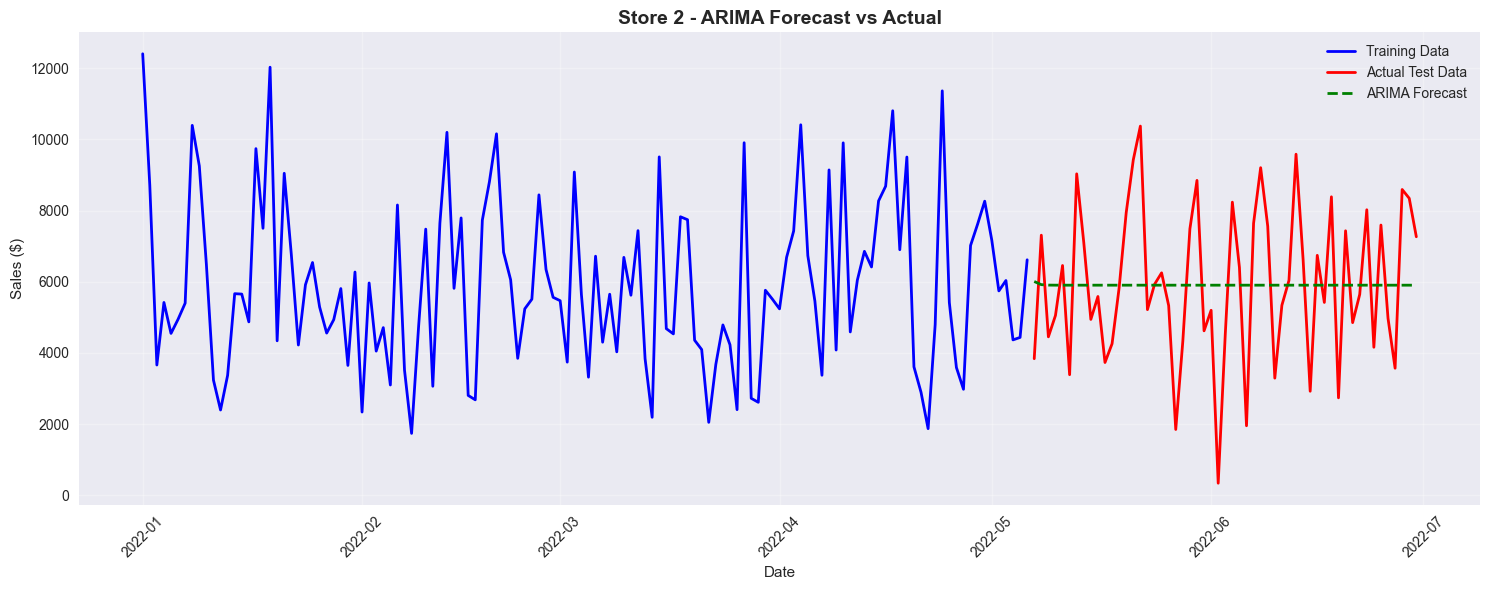

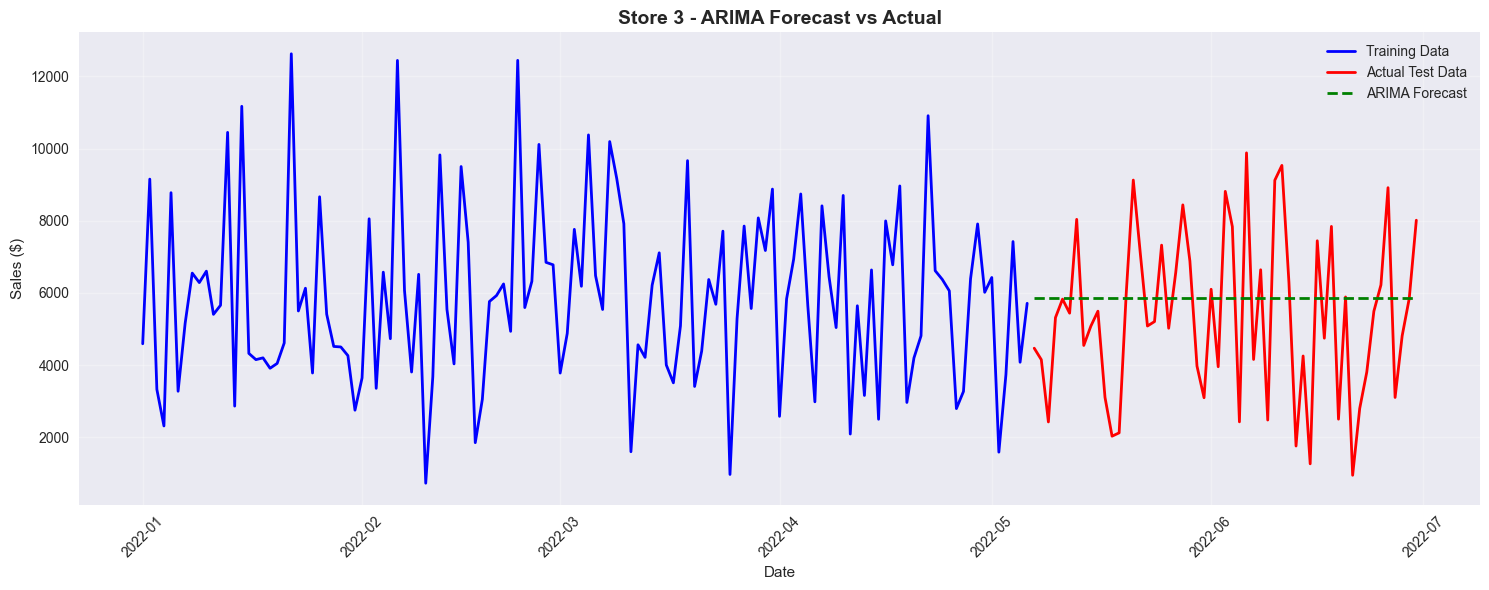

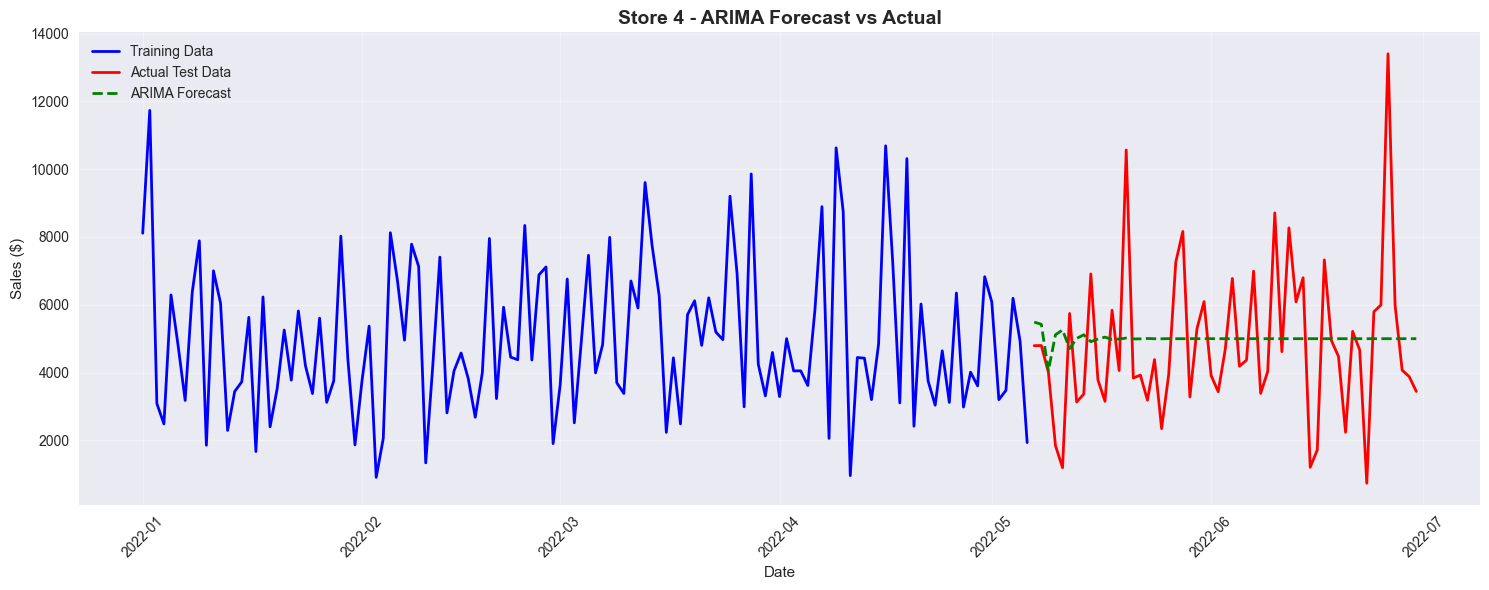

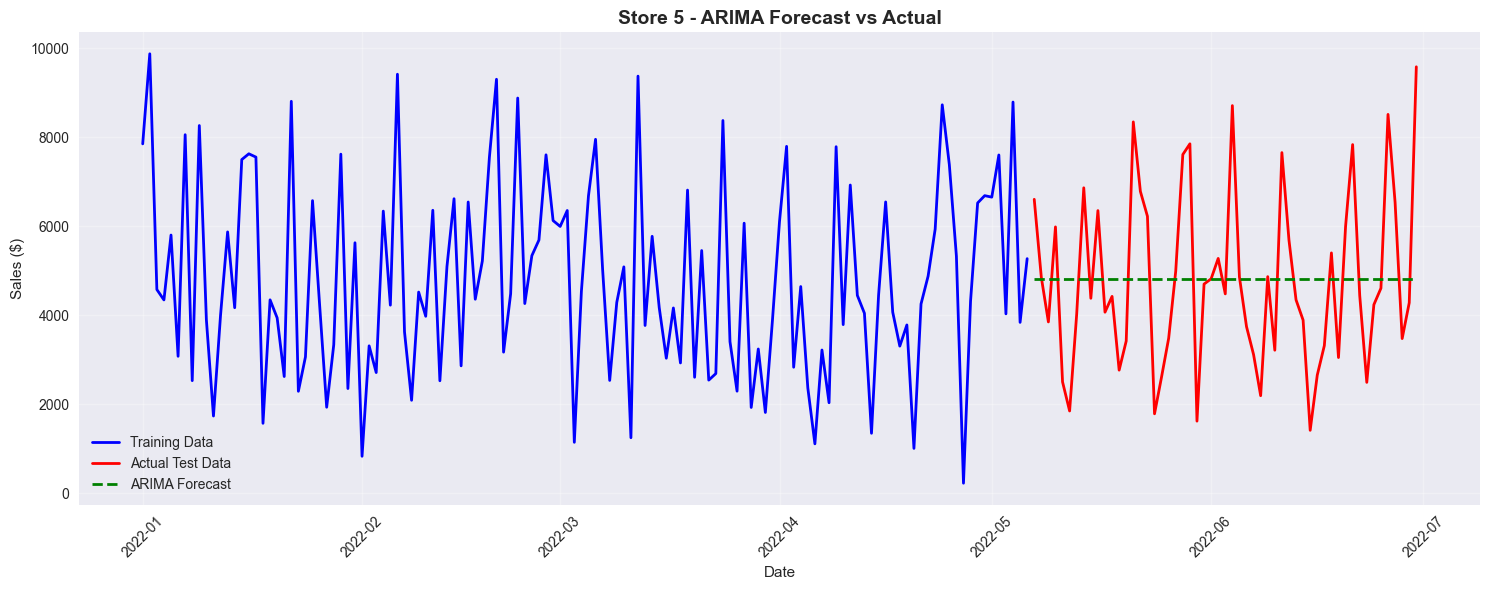

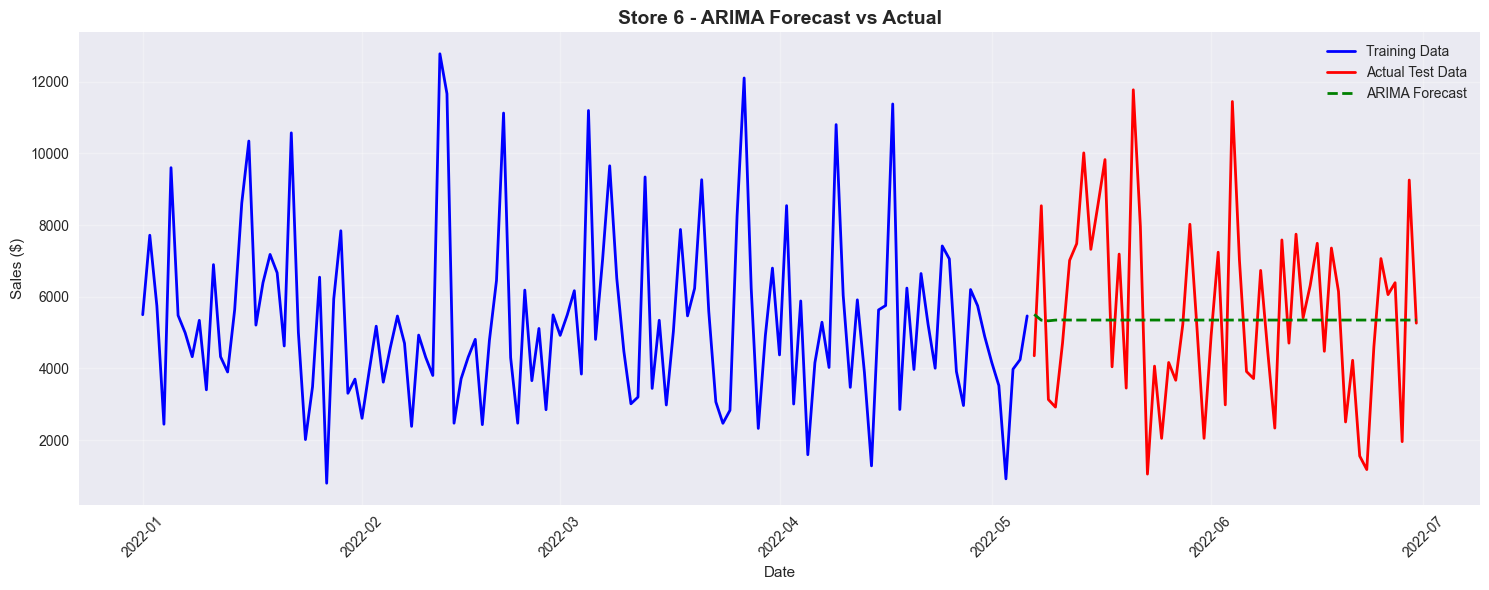

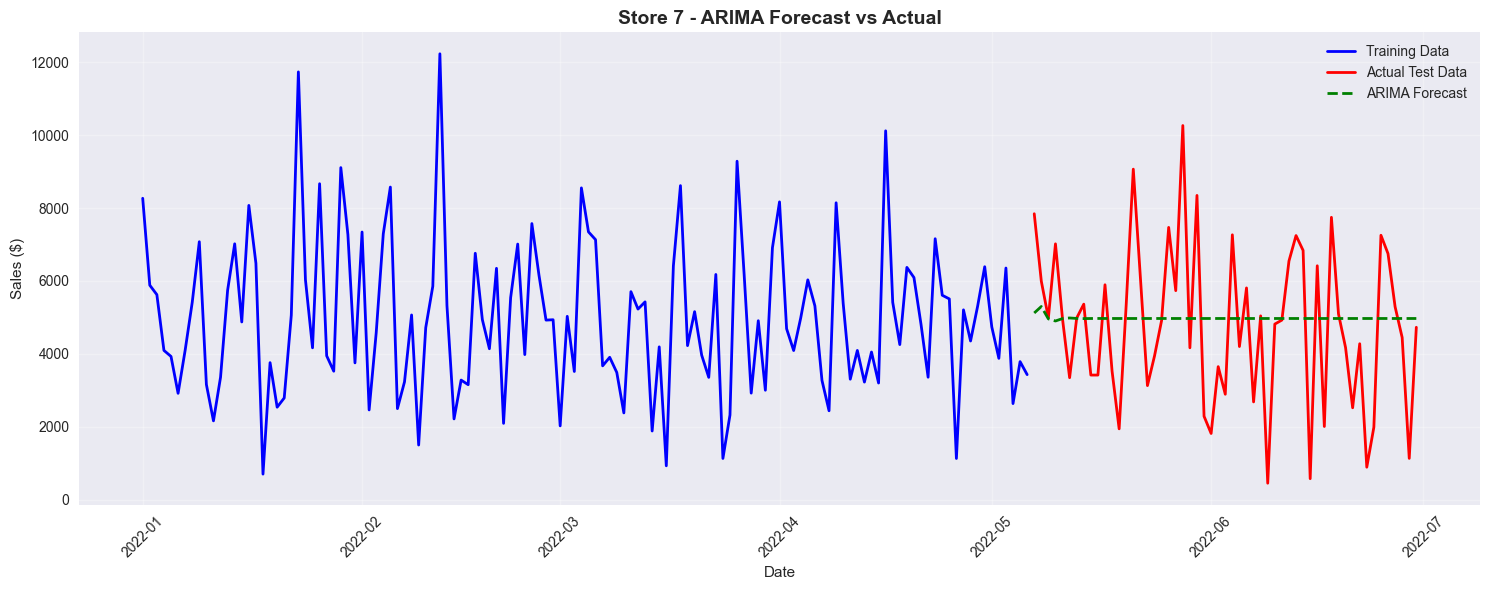

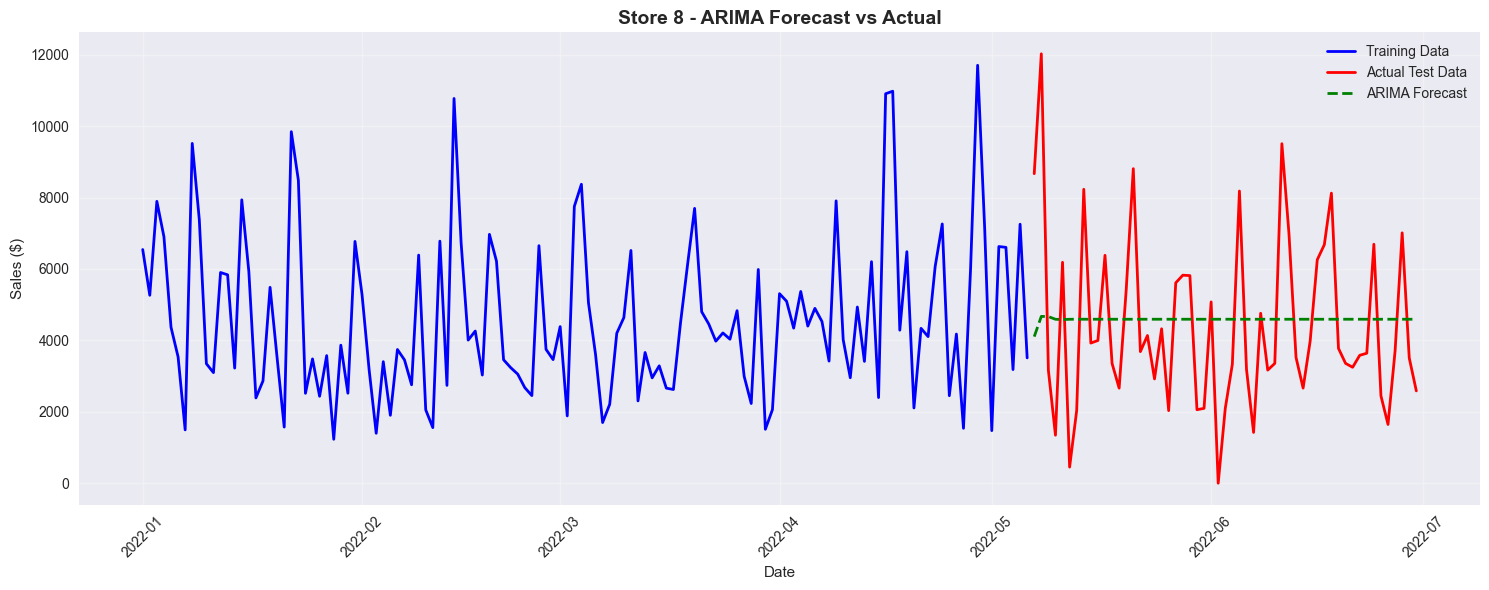

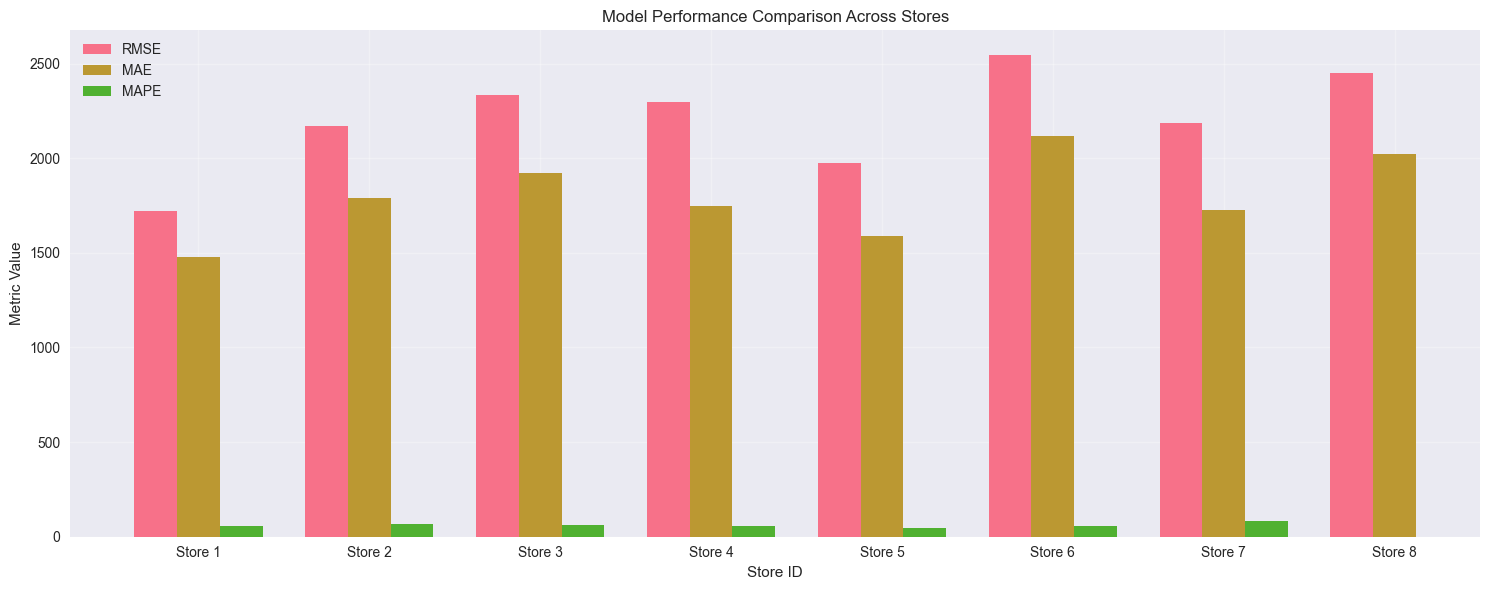

In [28]:
# Visualize forecasts for each store
for store_id, result in results.items():
    train = result['train']
    test = result['test']
    forecast = result['forecast']
    
    plt.figure(figsize=(15, 6))
    plt.plot(train.index, train, label='Training Data', linewidth=2, color='blue')
    plt.plot(test.index, test, label='Actual Test Data', linewidth=2, color='red')
    plt.plot(test.index, forecast, label='ARIMA Forecast', linewidth=2, color='green', linestyle='--')
    
    plt.title(f'Store {store_id} - ARIMA Forecast vs Actual', fontsize=14, fontweight='bold')
    plt.xlabel('Date')
    plt.ylabel('Sales ($)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Compare model performance across stores
store_ids = list(results.keys())
rmse_values = [results[store_id]['metrics'][1] for store_id in store_ids]
mae_values = [results[store_id]['metrics'][2] for store_id in store_ids]
mape_values = [results[store_id]['metrics'][3] for store_id in store_ids]

plt.figure(figsize=(15, 6))
x = np.arange(len(store_ids))
width = 0.25

plt.bar(x - width, rmse_values, width, label='RMSE')
plt.bar(x, mae_values, width, label='MAE')
plt.bar(x + width, mape_values, width, label='MAPE')

plt.xlabel('Store ID')
plt.ylabel('Metric Value')
plt.title('Model Performance Comparison Across Stores')
plt.xticks(x, [f'Store {id}' for id in store_ids])
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Future Forecasting

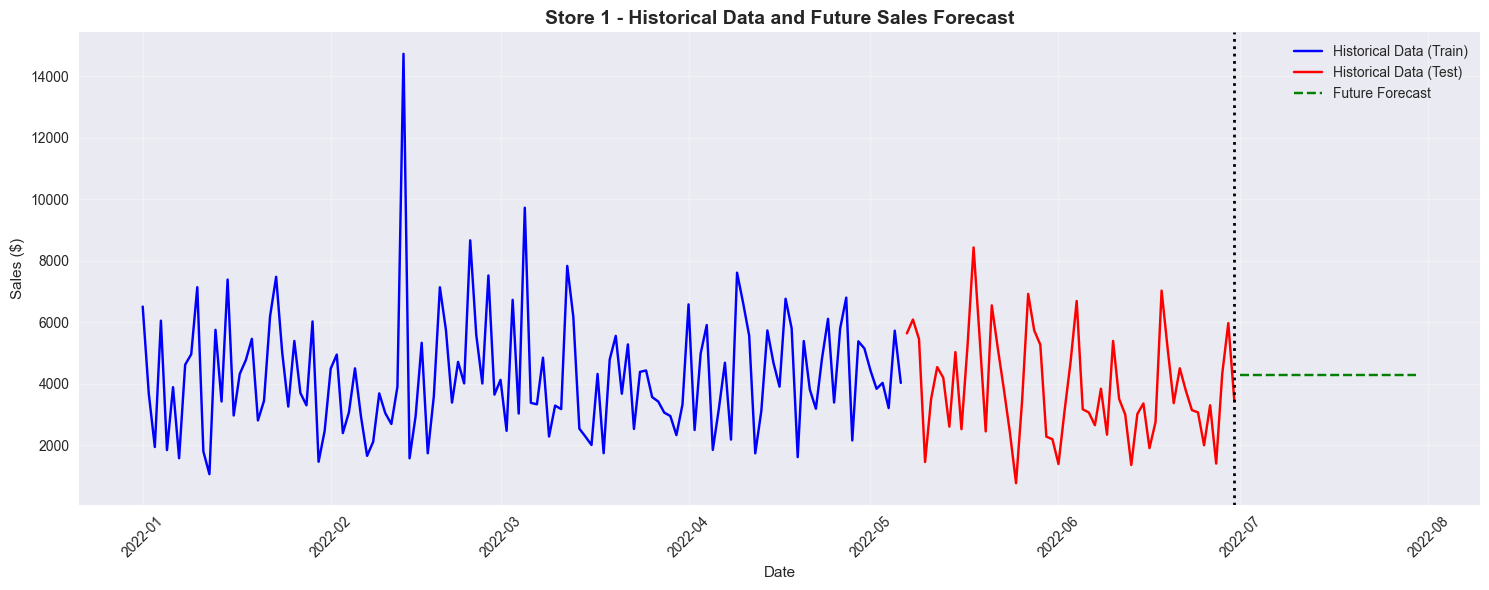


Future Sales Forecast for Store 1 (next 30 days):
2022-07-01: $4272.94
2022-07-02: $4272.94
2022-07-03: $4272.94
2022-07-04: $4272.94
2022-07-05: $4272.94
2022-07-06: $4272.94
2022-07-07: $4272.94
2022-07-08: $4272.94
2022-07-09: $4272.94
2022-07-10: $4272.94
2022-07-11: $4272.94
2022-07-12: $4272.94
2022-07-13: $4272.94
2022-07-14: $4272.94
2022-07-15: $4272.94
2022-07-16: $4272.94
2022-07-17: $4272.94
2022-07-18: $4272.94
2022-07-19: $4272.94
2022-07-20: $4272.94
2022-07-21: $4272.94
2022-07-22: $4272.94
2022-07-23: $4272.94
2022-07-24: $4272.94
2022-07-25: $4272.94
2022-07-26: $4272.94
2022-07-27: $4272.94
2022-07-28: $4272.94
2022-07-29: $4272.94
2022-07-30: $4272.94


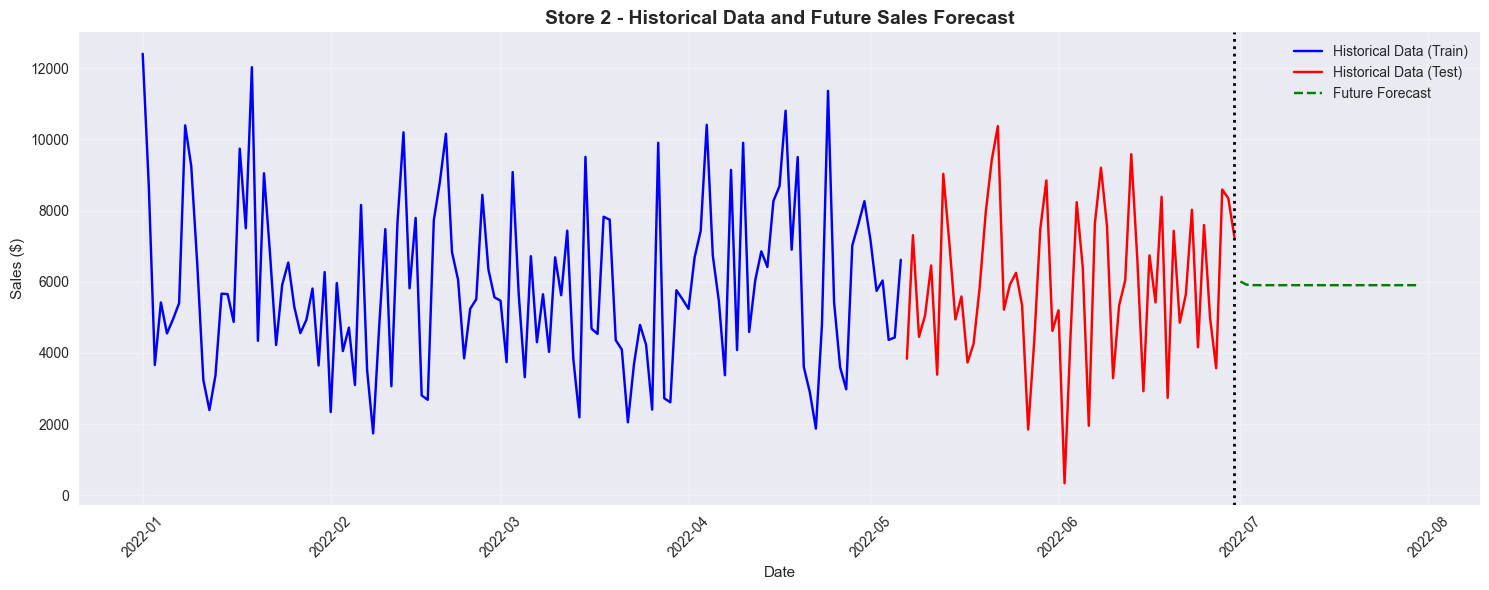


Future Sales Forecast for Store 2 (next 30 days):
2022-07-01: $6006.87
2022-07-02: $5918.45
2022-07-03: $5905.64
2022-07-04: $5903.79
2022-07-05: $5903.52
2022-07-06: $5903.48
2022-07-07: $5903.47
2022-07-08: $5903.47
2022-07-09: $5903.47
2022-07-10: $5903.47
2022-07-11: $5903.47
2022-07-12: $5903.47
2022-07-13: $5903.47
2022-07-14: $5903.47
2022-07-15: $5903.47
2022-07-16: $5903.47
2022-07-17: $5903.47
2022-07-18: $5903.47
2022-07-19: $5903.47
2022-07-20: $5903.47
2022-07-21: $5903.47
2022-07-22: $5903.47
2022-07-23: $5903.47
2022-07-24: $5903.47
2022-07-25: $5903.47
2022-07-26: $5903.47
2022-07-27: $5903.47
2022-07-28: $5903.47
2022-07-29: $5903.47
2022-07-30: $5903.47


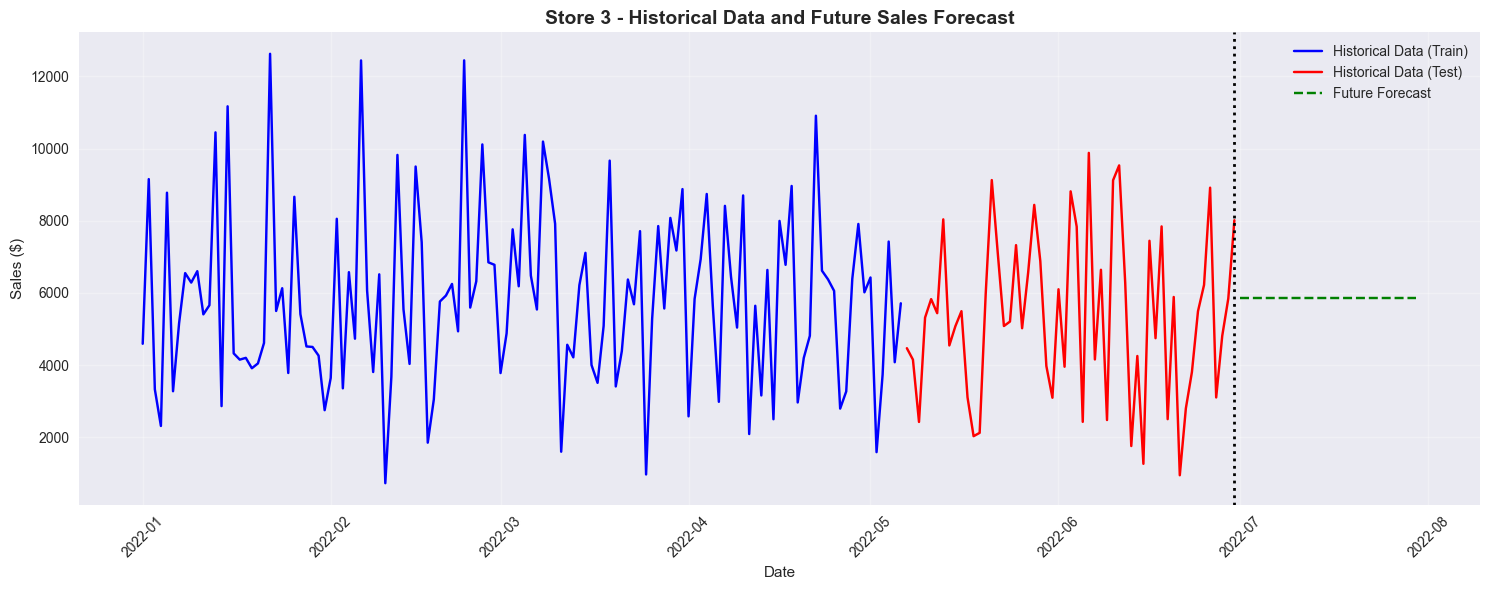


Future Sales Forecast for Store 3 (next 30 days):
2022-07-01: $5865.37
2022-07-02: $5865.37
2022-07-03: $5865.37
2022-07-04: $5865.37
2022-07-05: $5865.37
2022-07-06: $5865.37
2022-07-07: $5865.37
2022-07-08: $5865.37
2022-07-09: $5865.37
2022-07-10: $5865.37
2022-07-11: $5865.37
2022-07-12: $5865.37
2022-07-13: $5865.37
2022-07-14: $5865.37
2022-07-15: $5865.37
2022-07-16: $5865.37
2022-07-17: $5865.37
2022-07-18: $5865.37
2022-07-19: $5865.37
2022-07-20: $5865.37
2022-07-21: $5865.37
2022-07-22: $5865.37
2022-07-23: $5865.37
2022-07-24: $5865.37
2022-07-25: $5865.37
2022-07-26: $5865.37
2022-07-27: $5865.37
2022-07-28: $5865.37
2022-07-29: $5865.37
2022-07-30: $5865.37


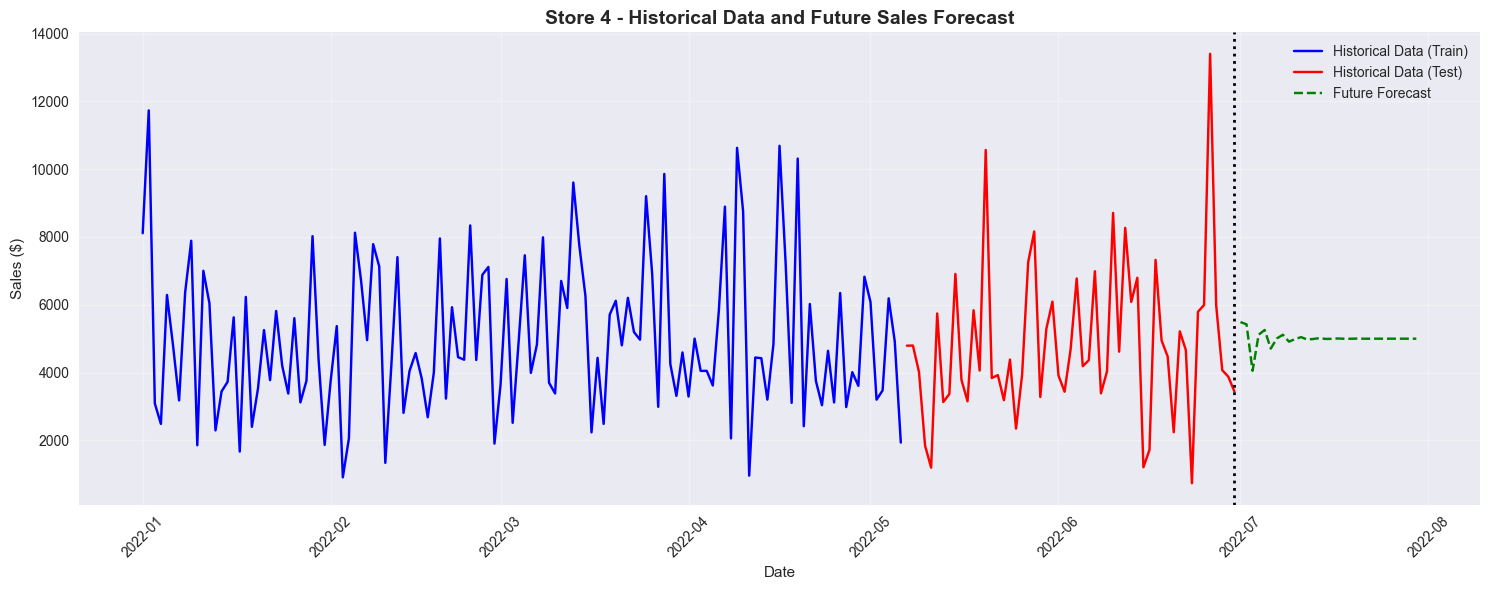


Future Sales Forecast for Store 4 (next 30 days):
2022-07-01: $5488.97
2022-07-02: $5423.13
2022-07-03: $4052.03
2022-07-04: $5115.44
2022-07-05: $5255.66
2022-07-06: $4705.54
2022-07-07: $5005.82
2022-07-08: $5114.45
2022-07-09: $4910.54
2022-07-10: $4987.11
2022-07-11: $5044.77
2022-07-12: $4973.67
2022-07-13: $4989.53
2022-07-14: $5015.66
2022-07-15: $4992.23
2022-07-16: $4993.77
2022-07-17: $5004.53
2022-07-18: $4997.27
2022-07-19: $4996.40
2022-07-20: $5000.54
2022-07-21: $4998.46
2022-07-22: $4997.68
2022-07-23: $4999.19
2022-07-24: $4998.66
2022-07-25: $4998.24
2022-07-26: $4998.76
2022-07-27: $4998.65
2022-07-28: $4998.46
2022-07-29: $4998.63
2022-07-30: $4998.62


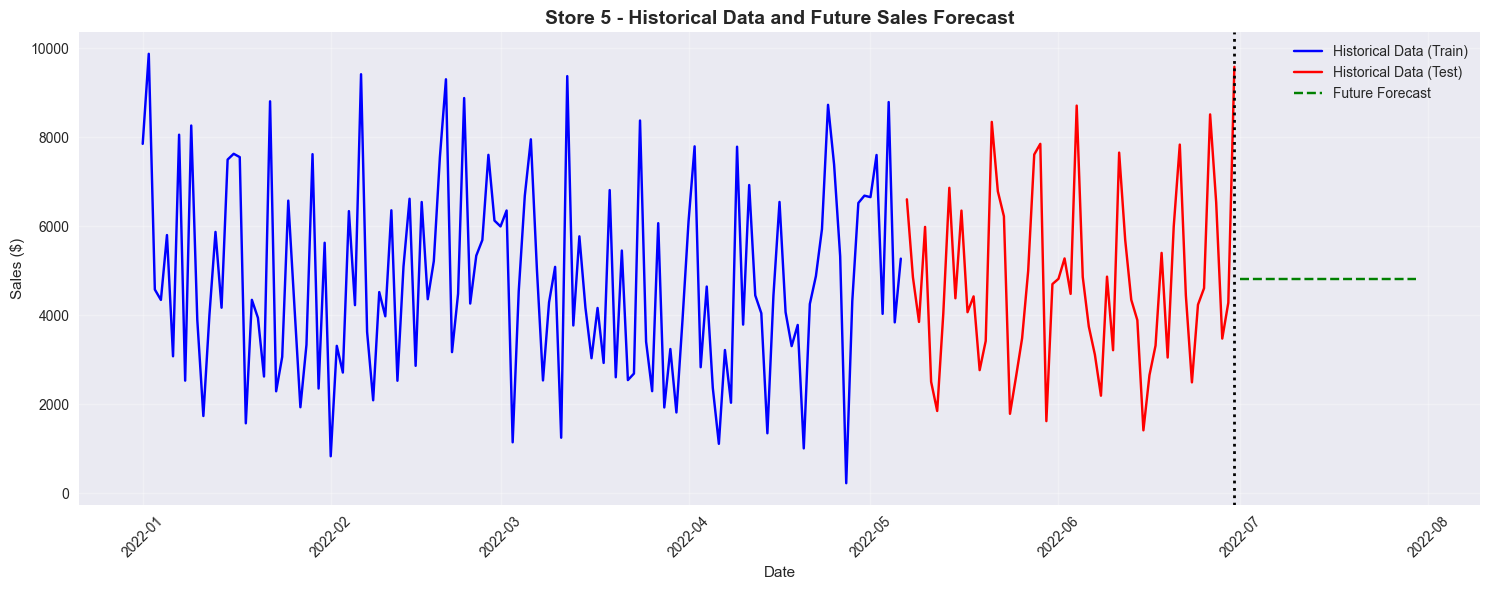


Future Sales Forecast for Store 5 (next 30 days):
2022-07-01: $4805.89
2022-07-02: $4805.89
2022-07-03: $4805.89
2022-07-04: $4805.89
2022-07-05: $4805.89
2022-07-06: $4805.89
2022-07-07: $4805.89
2022-07-08: $4805.89
2022-07-09: $4805.89
2022-07-10: $4805.89
2022-07-11: $4805.89
2022-07-12: $4805.89
2022-07-13: $4805.89
2022-07-14: $4805.89
2022-07-15: $4805.89
2022-07-16: $4805.89
2022-07-17: $4805.89
2022-07-18: $4805.89
2022-07-19: $4805.89
2022-07-20: $4805.89
2022-07-21: $4805.89
2022-07-22: $4805.89
2022-07-23: $4805.89
2022-07-24: $4805.89
2022-07-25: $4805.89
2022-07-26: $4805.89
2022-07-27: $4805.89
2022-07-28: $4805.89
2022-07-29: $4805.89
2022-07-30: $4805.89


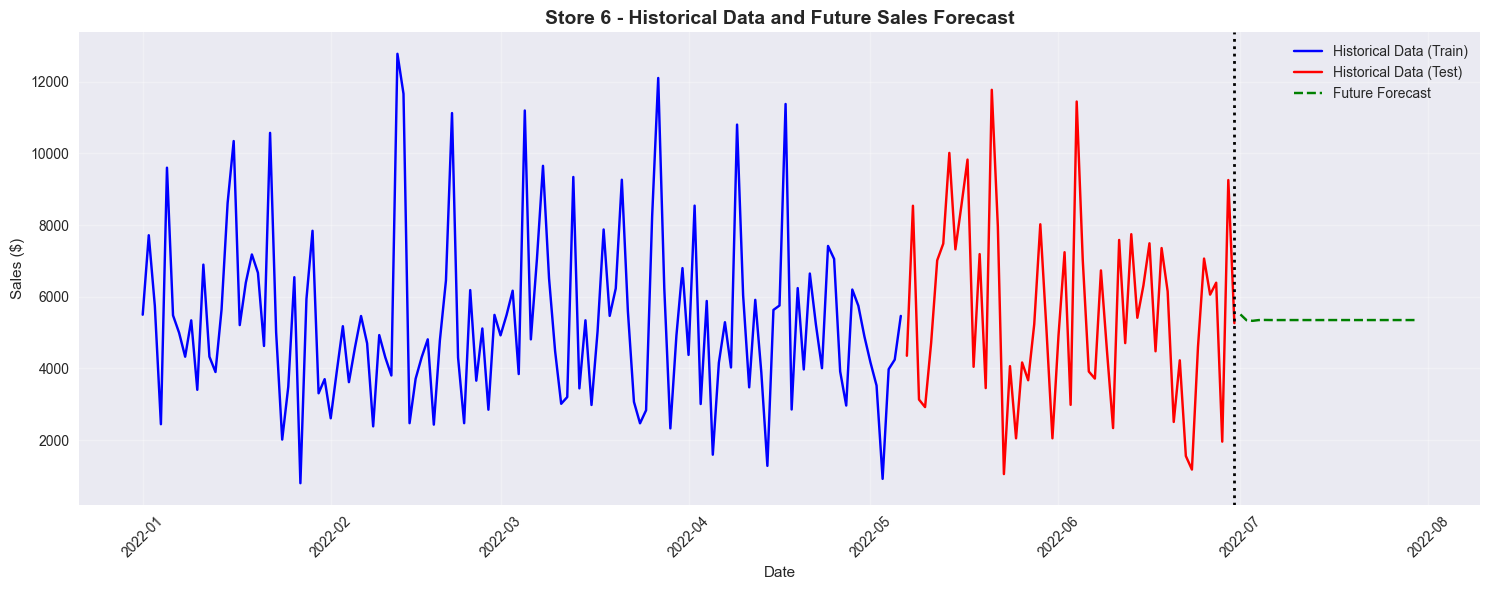


Future Sales Forecast for Store 6 (next 30 days):
2022-07-01: $5505.34
2022-07-02: $5343.95
2022-07-03: $5326.34
2022-07-04: $5346.80
2022-07-05: $5350.69
2022-07-06: $5348.21
2022-07-07: $5347.51
2022-07-08: $5347.79
2022-07-09: $5347.90
2022-07-10: $5347.88
2022-07-11: $5347.86
2022-07-12: $5347.86
2022-07-13: $5347.86
2022-07-14: $5347.86
2022-07-15: $5347.86
2022-07-16: $5347.86
2022-07-17: $5347.86
2022-07-18: $5347.86
2022-07-19: $5347.86
2022-07-20: $5347.86
2022-07-21: $5347.86
2022-07-22: $5347.86
2022-07-23: $5347.86
2022-07-24: $5347.86
2022-07-25: $5347.86
2022-07-26: $5347.86
2022-07-27: $5347.86
2022-07-28: $5347.86
2022-07-29: $5347.86
2022-07-30: $5347.86


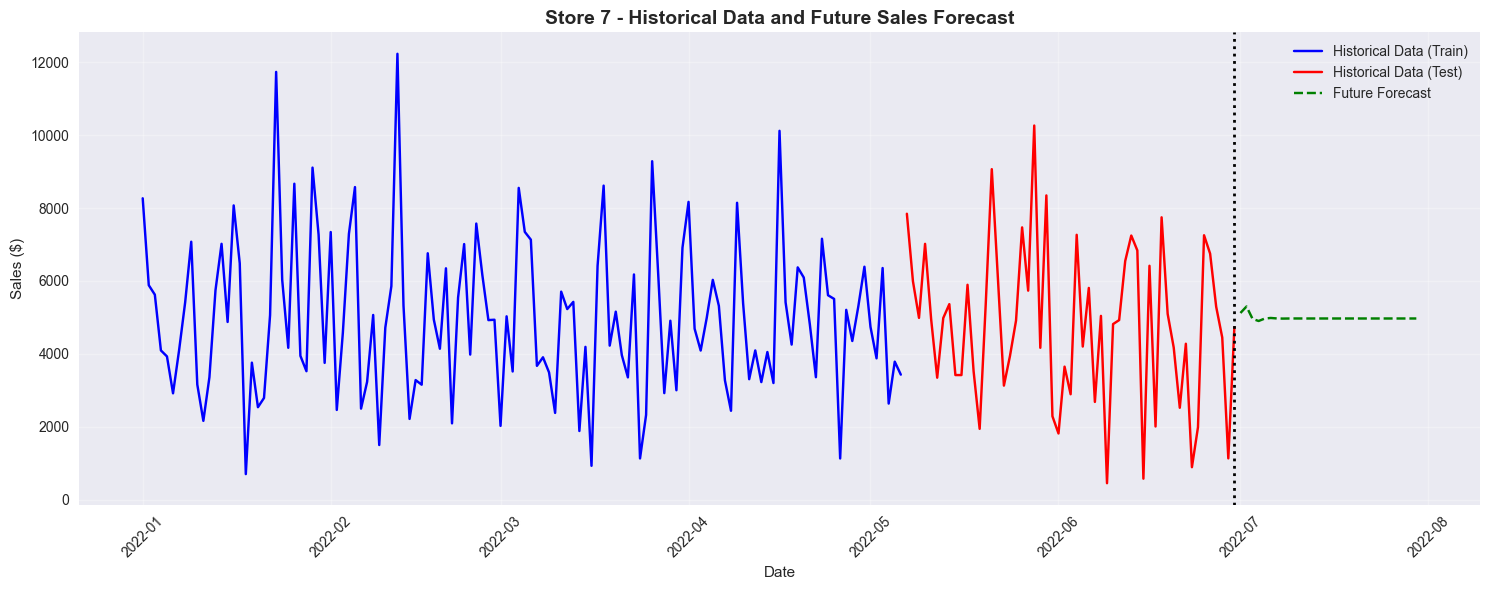


Future Sales Forecast for Store 7 (next 30 days):
2022-07-01: $5121.04
2022-07-02: $5298.66
2022-07-03: $4958.68
2022-07-04: $4901.02
2022-07-05: $4967.97
2022-07-06: $4984.02
2022-07-07: $4971.13
2022-07-08: $4967.01
2022-07-09: $4969.43
2022-07-10: $4970.43
2022-07-11: $4969.99
2022-07-12: $4969.76
2022-07-13: $4969.83
2022-07-14: $4969.89
2022-07-15: $4969.88
2022-07-16: $4969.86
2022-07-17: $4969.87
2022-07-18: $4969.87
2022-07-19: $4969.87
2022-07-20: $4969.87
2022-07-21: $4969.87
2022-07-22: $4969.87
2022-07-23: $4969.87
2022-07-24: $4969.87
2022-07-25: $4969.87
2022-07-26: $4969.87
2022-07-27: $4969.87
2022-07-28: $4969.87
2022-07-29: $4969.87
2022-07-30: $4969.87


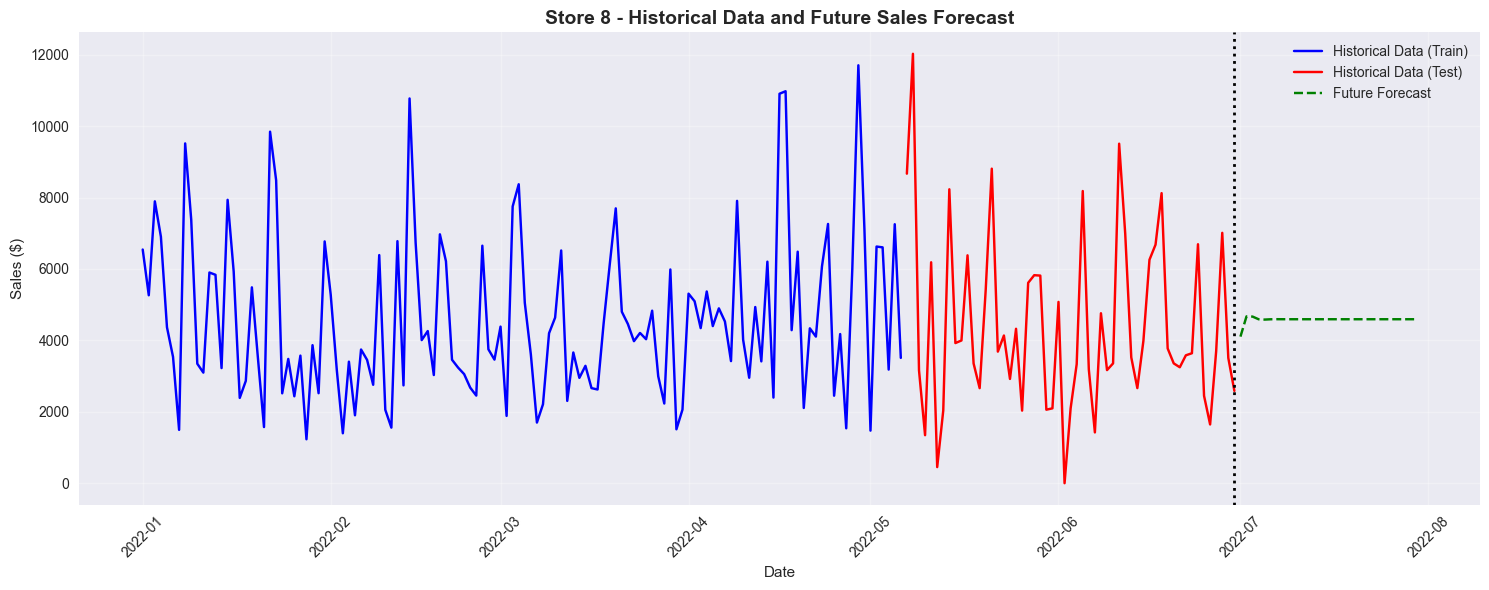


Future Sales Forecast for Store 8 (next 30 days):
2022-07-01: $4104.72
2022-07-02: $4671.81
2022-07-03: $4666.20
2022-07-04: $4591.10
2022-07-05: $4582.24
2022-07-06: $4590.96
2022-07-07: $4593.23
2022-07-08: $4592.38
2022-07-09: $4591.97
2022-07-10: $4592.03
2022-07-11: $4592.09
2022-07-12: $4592.09
2022-07-13: $4592.09
2022-07-14: $4592.09
2022-07-15: $4592.09
2022-07-16: $4592.09
2022-07-17: $4592.09
2022-07-18: $4592.09
2022-07-19: $4592.09
2022-07-20: $4592.09
2022-07-21: $4592.09
2022-07-22: $4592.09
2022-07-23: $4592.09
2022-07-24: $4592.09
2022-07-25: $4592.09
2022-07-26: $4592.09
2022-07-27: $4592.09
2022-07-28: $4592.09
2022-07-29: $4592.09
2022-07-30: $4592.09


In [29]:
# Future forecasting for each store
future_steps = 30  # Forecast next 30 days

for store_id, result in results.items():
    model = result['model']
    
    # Generate future forecast
    future_forecast = model.forecast(steps=future_steps)
    
    # Generate future dates
    last_date = df_long['Date'].max()
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=future_steps, freq='D')
    
    # Plot historical + forecast
    plt.figure(figsize=(15, 6))
    plt.plot(result['train'].index, result['train'], label='Historical Data (Train)', color='blue')
    plt.plot(result['test'].index, result['test'], label='Historical Data (Test)', color='red')
    plt.plot(future_dates, future_forecast, label='Future Forecast', color='green', linestyle='--')
    
    plt.title(f'Store {store_id} - Historical Data and Future Sales Forecast', fontsize=14, fontweight='bold')
    plt.xlabel('Date')
    plt.ylabel('Sales ($)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    
    # Add vertical line to separate historical from forecast
    plt.axvline(x=last_date, color='black', linestyle=':', linewidth=2, label='Forecast Start')
    
    plt.tight_layout()
    plt.show()
    
    # Print future forecast values
    print(f"\nFuture Sales Forecast for Store {store_id} (next 30 days):")
    for date, value in zip(future_dates, future_forecast):
        print(f"{date.strftime('%Y-%m-%d')}: ${value:.2f}")

## Summary and Insights

In [30]:
# Create summary table of metrics
summary_df = pd.DataFrame({
    'Store': store_ids,
    'RMSE': rmse_values,
    'MAE': mae_values,
    'MAPE': mape_values
})

print("\nSummary of Model Performance:")
print(summary_df)

# Find best and worst performing stores
best_store = summary_df.loc[summary_df['RMSE'].idxmin()]['Store']
worst_store = summary_df.loc[summary_df['RMSE'].idxmax()]['Store']

print(f"\nBest performing model: Store {int(best_store)} with RMSE {summary_df['RMSE'].min():.2f}")
print(f"Worst performing model: Store {int(worst_store)} with RMSE {summary_df['RMSE'].max():.2f}")

# Provide business insights
print("\nKey Insights:")
print("1. The data shows clear differences in sales patterns between stores")
print("2. Some stores exhibit stronger seasonal patterns than others")
print("3. The ARIMA model performs better for stores with more consistent sales patterns")
print("4. For stores with high volatility, more complex models or additional features may be needed")
print("5. Consider using external factors like promotions, holidays, or weather data to improve forecasts")


Summary of Model Performance:
   Store         RMSE          MAE       MAPE
0      1  1721.244024  1477.042778  57.124831
1      2  2170.058226  1791.062942  65.149165
2      3  2332.918162  1920.858922  60.642267
3      4  2296.680464  1746.973585  57.311696
4      5  1972.992902  1589.560345  43.565644
5      6  2548.255305  2115.403264  57.522185
6      7  2185.756587  1728.949640  82.576685
7      8  2449.314668  2022.219448        inf

Best performing model: Store 1 with RMSE 1721.24
Worst performing model: Store 6 with RMSE 2548.26

Key Insights:
1. The data shows clear differences in sales patterns between stores
2. Some stores exhibit stronger seasonal patterns than others
3. The ARIMA model performs better for stores with more consistent sales patterns
4. For stores with high volatility, more complex models or additional features may be needed
5. Consider using external factors like promotions, holidays, or weather data to improve forecasts
